# Univariate fMRI analysis -  yes v. no response activations

Data from HCP social task (Barch et al, 2013, van Essen et al, 2013 - NeuroImage)

- This script has the code I used for the fMRI analyses mentioned in the OHBM abstract (improved now)

- Here each movie was modelled separately using two linear models: BOLD = f(stimPresence), stimPresence &isin; {0,1} and BOLD = f(normalized TR#). I refer to these as the block and the slope regressor, resp.
- The resultant beta values for each sub, node and movie, can be used to compare brain activity between subject groups who responded 'yes'/'social' and 'no'/'nonsocial' using button presses in the scanner

- I did this comparison using
(1) unpaired t-tests for each node of the most ambiguous movie (random mechanical) and plotted the T-scores on a brain map thresholded at p =.05 (fdr corr. at .05), and 
(2) selecting only common subjects and performing paired t-tests across subjects for movies with comparable decision times (from a separate online expt). also thresholded and fdr corrected like before

- Ignore the section 'extra' in the end

Rekha Varrier, Oct 7

In [1]:
# import packages, check folders
#%reset
import os
import numpy as np
import h5py
import pandas as pd
#import imagesc as imagesc #pip install imagesc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from pathlib import Path
from datetime import datetime

# TO DO - REMOVE THE UNNECESSARY LIBRARY IMPORTS

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


Now let's get working on the dataset. First we need to extract the data per trial + fixations

In [2]:
# setting default fontsizes for plots

s=16 # CHANGE FONTSIZE HERE

plt.rc('font', size=s) #controls default text size
plt.rc('axes', titlesize=s) #fontsize of the title
plt.rc('axes', labelsize=s) #fontsize of the x and y labels
plt.rc('xtick', labelsize=s) #fontsize of the x tick labels
plt.rc('ytick', labelsize=s) #fontsize of the y tick labels
plt.rc('legend', fontsize=s) #fontsize of the legend
#import matplotlib as mpl
#mpl.rcParams['font.weight']= 'normal'


In [3]:
# order of movies - constant across subjects. useful to display while running analyses

vid_names = {}
#vid_names["run1"] = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical"]
#vid_names["run2"] = ["Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
movie_types = [1,0,0,1,0,1,1,0,1,0] # based on general responses. 1 is for social, 0 for nonsocial
vid_joined = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical","Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vid_joined

['COAXING-B',
 'BILLIARD-A',
 'DRIFTING-A',
 'Fishing',
 'Random mechanical',
 'Scaring',
 'SEDUCING-B',
 'STAR-A',
 'SURPRISING-B',
 'TENNIS-A']

In [4]:
[timepts_indiv_movie,vid_start_rel_tr] = np.load(os.path.join(data_file_loc,'Video_TRs.npy'),allow_pickle=True)
l_task = 28
tcs_run_z = np.load(os.path.join(data_file_loc,'timecourses_run_norm',f'timecourse-all-movies_zscorenorm.npy'))  # movie wise timecourses from tr-14:tr+14
tcs_run_z.shape


(1048, 268, 56, 10)

In [5]:
tcs_trial_z = np.load(os.path.join(data_file_loc,'timecourses_trial_norm',f'timecourse-all-movies_zscorenorm.npy'))  # movie wise timecourses from tr-14:tr+14
tcs_trial_z.shape


(1048, 268, 56, 10)

In [6]:
responses = np.load(os.path.join(data_file_loc,'responses.npy')) # load beh responses

# A la traditional-GLM analysis: BOLD timecourse = f(movie)

- The GLM is done at the trial level i.e., each timecourse spans from t-14 to t+28 +14 (if t is the onset TR, except movie 1)

- first analysis is simple - for each movie, node and subject, we create a block regressor including the movie time windows + fixations before and after it. Then we fit the equation: BOLD = b0+b1*stimPresence, and compare b1 across subjects responses etc. (stimPresence = 1 during the video block and 0 otherwise)
- along with that, a parallel analysis uses a slope regressor indicating changes across time: BOLD = b0+b1*stimTime


### defining the HRF

Text(0.5, 0, 'Time')

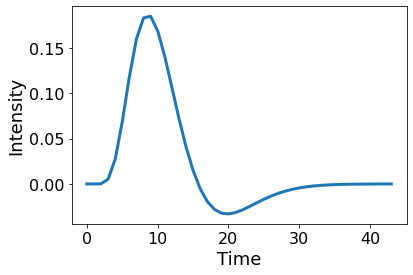

In [7]:
#defining the hrf
from nltools.external import glover_hrf

tr = .72
#hrf function
hrf = glover_hrf(tr, oversampling=1)
plt.plot(hrf, linewidth=3)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Time', fontsize=18)

## Creating the convolved block and slope regressors

In [8]:
# function needed for the GLM
from sklearn.linear_model import LinearRegression
from multiprocessing import Pool
from joblib import cpu_count


/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/Users/f0053cz/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


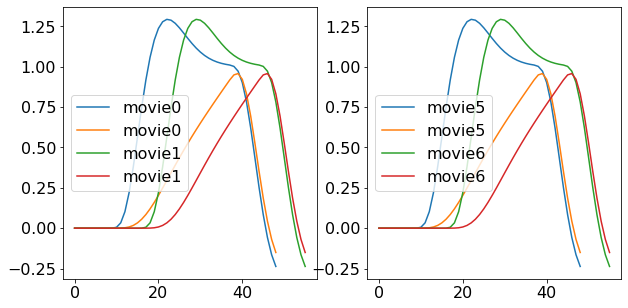

In [9]:
# illustrating the convolution
plt.figure(1,figsize = (10,5))
for vid_no in [0,1,5,6]:
    
    reg_block = np.zeros((len(timepts_indiv_movie[vid_no]),))
    reg_slope = np.zeros_like(reg_block)

    inds = np.arange(vid_start_rel_tr[vid_no],vid_start_rel_tr[vid_no]+l_task)
    
    reg_block[inds] = 1 
    reg_block = np.convolve(reg_block, hrf)[:len(reg_block)]
    reg_slope[inds] = np.linspace(.01,1,len(inds))
    reg_slope = np.convolve(reg_slope, hrf)[:len(reg_slope)]
    
    if vid_no < 5:
        plt.subplot(1,2,1)
    else:
        plt.subplot(1,2,2)

    if vid_no%5==0:
        plt.plot(reg_block,label = f'movie{vid_no}')
        plt.plot(reg_slope,label = f'movie{vid_no}')
    if vid_no%5!=0:
        plt.plot(reg_block,label = f'movie{vid_no}')
        plt.plot(reg_slope,label = f'movie{vid_no}')
    plt.legend()

### GLM

- Next,we perform a linear regression for each subject, movie (trial) and node. This takes about 3-4mins, so skip to quickly load data stored previously


In [10]:
timepts_indiv_movie[0].shape

(49,)

In [11]:
vid_start_rel_tr

array([7, 14, 14, 14, 14, 7, 14, 14, 14, 14], dtype=object)

In [12]:
# functions that will be parallelized across nodes. For use in the next cell

def lm_estimate_blockreg(Y):
    # function to perform a linear regression using a block regressor and to return the reg. coefft.
    # dims of Y = timecourse + movie ind
    
    reg_block = np.zeros((len(timepts_indiv_movie[movie_ind]),))
    inds = np.arange(vid_start_rel_tr[movie_ind],vid_start_rel_tr[movie_ind]+l_task)
    reg_block[inds] = 1 
    reg_block = np.convolve(reg_block, hrf)[:len(reg_block)]
    reg_block = reg_block.reshape(-1, 1)
    
    model = LinearRegression().fit(reg_block, Y) # block regressor
    return model.coef_[0] 

def lm_estimate_slopereg(Y):
    # function to perform a linear regression using  an ascending (slope) regressor and to return the reg. coefft.
    # dims of Y = timecourse + movie ind
        
    reg_slope = np.zeros((len(timepts_indiv_movie[movie_ind]),))
    inds = np.arange(vid_start_rel_tr[movie_ind],vid_start_rel_tr[movie_ind]+l_task) # from the image index 1 (i.e., t=.72 after vid starts)
    # to image index 1+28
    reg_slope[inds] = np.linspace(.01,1,len(inds))
    reg_slope = np.convolve(reg_slope, hrf)[:len(reg_slope)]
    reg_slope = reg_slope.reshape(-1, 1)
    
    model = LinearRegression().fit(reg_slope, Y) # slope regressor
    return model.coef_[0] 

In [13]:

def linReg(dat,fileName,regType):
    # performs linear regression across all subjects,nodes and movies for the data and regression type entered, and saves and returns the regressors
    # dat dimensions: nsub *nnodes*ntimepts*nmovies
    coef_ = np.empty((dat.shape[0],dat.shape[1])) # variable to store the regression coeffts or beta estimates for each subject and row

    start = time.time()

    if __name__ == '__main__':
        pool = Pool(processes=cpu_count()) # helps to parallelize processing

    print('movie_ind:',movie_ind)
    
    for s in range(dat.shape[0]): # number of subjects
        # print(s)
        if s%200 == 0:
            now = time.time()
            print(f'sub:{s}, time elapsed:{(now - start)/60:.2f}mins')

        #coef_blockreg_runnorm[s,:,movie_ind] = np.array([LinearRegression().fit(X, tcs_run_z[s,n,:,movie_ind]).coef_[0] for n in range(tcs_run_z.shape[1])])
        
        tcs = [y for y in dat[s,:,:]] # list of length nnodes (268), each element of the list is a [32,] timcourse array
        if regType == 'block':
            #print('block..')
            coef_[s,:] = pool.map(lm_estimate_blockreg,tcs) # estimate returned as a list of size 268
        elif regType == 'slope':
            #print('slope..')
            coef_[s,:] = pool.map(lm_estimate_slopereg,tcs) # estimate returned as a list of size 268
        
    now = time.time()
    print(f'Done.total time:{(now-start)/60:.2f}mins')

    np.save(fileName,coef_)
    return coef_


#### All movies

- estimating trial wise regressors to do an all movies social > unsure > nonsocial analysis in 2B_2_ fmri....soc_v_unsure_v_nonsocial.ipynb

In [14]:
vid_start_rel_tr

array([7, 14, 14, 14, 14, 7, 14, 14, 14, 14], dtype=object)

In [16]:
# Slope regressor, trial-norm data (all except coax/bill)

movie_inds = [2,3,4,5,6,7,8,9] # movies not included in other comparisons
coef_slopereg_trialnorm_others= np.empty((tcs_trial_z.shape[0],tcs_trial_z.shape[1],len(movie_inds)))
coef_slopereg_trialnorm_others[:] = np.nan
for i,movie_ind in enumerate(movie_inds):
    
    print('Slope','trial norm,' ,vid_joined[movie_ind])
    fileName = os.path.join(data_file_loc,f'coef_slopereg_trialnorm_{vid_joined[movie_ind]}.npy')
    print(fileName)
    
    coef_slopereg_trialnorm_others[:,:,i] = linReg(tcs_trial_z[:,:,:vid_start_rel_tr[movie_ind]+l_task+14,movie_ind],fileName,'slope')
    # adding indices for the timepts because for the movie 0, there were only data up to vid_onset_TR(7)+28+14 (49 timepts instead of the usual 56)

# here we need to remove subs with too few responses later!!



Slope trial norm, DRIFTING-A
/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/coef_slopereg_trialnorm_DRIFTING-A.npy
movie_ind: 2
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.08mins
sub:400, time elapsed:0.18mins
sub:600, time elapsed:0.26mins
sub:800, time elapsed:0.37mins
sub:1000, time elapsed:0.50mins
Done.total time:0.52mins
Slope trial norm, Fishing
/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/coef_slopereg_trialnorm_Fishing.npy
movie_ind: 3
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.12mins
sub:400, time elapsed:0.24mins
sub:600, time elapsed:0.35mins
sub:800, time elapsed:0.45mins
sub:1000, time elapsed:0.55mins
Done.total time:0.56mins
Slope trial norm, Random mechanical
/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/coef_slopereg_trialnorm_Random mechanical.npy
movie_ind: 4
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.15mins
sub:400, time elapsed:0.40

### Within- movie (RAND, FISH etc)

In [60]:
# Block regressor, run norm (bill,fishing, rand)

movie_inds = [2,3,4,9]
reg_block = reg_block.reshape((-1, 1))

coef_blockreg_runnorm= np.empty((tcs_run_z.shape[0],tcs_run_z.shape[1],len(movie_inds)))
coef_blockreg_runnorm[:] = np.nan

for i,movie_ind in enumerate(movie_inds):
    ts = timepts_indiv_movie[movie_ind]
    if movie_ind % 5 ==0:
        print('add code!!!!!')
    else:
        print('Block','runnorm,' ,vid_joined[movie_ind])
        fileName = os.path.join(data_file_loc,f'coef_blockreg_runnorm_{vid_joined[movie_ind]}.npy')
        print(fileName)
        coef_blockreg_runnorm[:,:,i] = linReg(tcs_run_z[:,:,:,movie_ind],fileName,'block')
print('\n\nData saved on/at:',datetime.now()) # cell run at


Block runnorm, DRIFTING-A
/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/coef_blockreg_runnorm_DRIFTING-A.npy
movie_ind: 2
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.06mins
sub:400, time elapsed:0.13mins
sub:600, time elapsed:0.19mins
sub:800, time elapsed:0.25mins
sub:1000, time elapsed:0.31mins
Done.total time:0.33mins
Block runnorm, Fishing
/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/coef_blockreg_runnorm_Fishing.npy
movie_ind: 3
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.08mins
sub:400, time elapsed:0.15mins
sub:600, time elapsed:0.22mins
sub:800, time elapsed:0.29mins
sub:1000, time elapsed:0.37mins
Done.total time:0.39mins
Block runnorm, Random mechanical
/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/coef_blockreg_runnorm_Random mechanical.npy
movie_ind: 4
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.11mins
sub:400, time elapsed:0.21mins
sub:600, t

In [61]:
# Slope regressor, run norm (bill,fishing, rand)

movie_inds = [2,3,4,9]
reg_slope = reg_slope.reshape((-1, 1))

coef_slopereg_runnorm= np.empty((tcs_run_z.shape[0],tcs_run_z.shape[1],len(movie_inds)))
coef_slopereg_runnorm[:] = np.nan

for i,movie_ind in enumerate(movie_inds):

    ts = timepts_indiv_movie[movie_ind]

    if movie_ind % 5 ==0:
        print('add code!!!!!')
        
    else:
        print('\nSlope','runnorm,',vid_joined[movie_ind])
        fileName = os.path.join(data_file_loc,f'coef_slopereg_runnorm_{vid_joined[movie_ind]}.npy')
        coef_slopereg_runnorm[:,:,i] = linReg(tcs_run_z[:,:,:,movie_ind],fileName,'slope')

print('\n\nData saved on/at:',datetime.now()) # cell run at



Slope runnorm, DRIFTING-A
movie_ind: 2
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.12mins
sub:400, time elapsed:0.21mins
sub:600, time elapsed:0.31mins
sub:800, time elapsed:0.41mins
sub:1000, time elapsed:0.52mins
Done.total time:0.55mins

Slope runnorm, Fishing
movie_ind: 3
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.13mins
sub:400, time elapsed:0.26mins
sub:600, time elapsed:0.39mins
sub:800, time elapsed:0.49mins
sub:1000, time elapsed:0.59mins
Done.total time:0.62mins

Slope runnorm, Random mechanical
movie_ind: 4
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.10mins
sub:400, time elapsed:0.23mins
sub:600, time elapsed:0.37mins
sub:800, time elapsed:0.50mins
sub:1000, time elapsed:0.63mins
Done.total time:0.66mins

Slope runnorm, TENNIS-A
movie_ind: 9
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.14mins
sub:400, time elapsed:0.28mins
sub:600, time elapsed:0.41mins
sub:800, time elapsed:0.51mins
sub:1000, time elapsed:0.62mins
Done.total time:0.65min

### coax/bill

In [16]:
# Block regressor, trial-norm data (coax/bill)

movie_inds = [0,1]

coef_blockreg_trialnorm = np.empty((tcs_trial_z.shape[0],tcs_trial_z.shape[1],len(movie_inds)))
coef_blockreg_trialnorm[:] = np.nan
for i,movie_ind in enumerate(movie_inds):
    
    print('Block','trial norm,' ,vid_joined[movie_ind])
    fileName = os.path.join(data_file_loc,f'coef_blockreg_trialnorm_{vid_joined[movie_ind]}.npy')
    print(fileName)
    
    coef_blockreg_trialnorm[:,:,i] = linReg(tcs_trial_z[:,:,:vid_start_rel_tr[movie_ind]+l_task+14,movie_ind],fileName,'block')
    # adding indices for the timepts because for the movie 0, there were only data up to vid_onset_TR(7)+28+14 (49 timepts instead of the usual 56)

Block trial norm, COAXING-B
/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/coef_blockreg_trialnorm_COAXING-B.npy
movie_ind: 0
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.07mins
sub:400, time elapsed:0.14mins
sub:600, time elapsed:0.20mins
sub:800, time elapsed:0.28mins
sub:1000, time elapsed:0.34mins
Done.total time:0.36mins
Block trial norm, BILLIARD-A
/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/coef_blockreg_trialnorm_BILLIARD-A.npy
movie_ind: 1
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.08mins
sub:400, time elapsed:0.15mins
sub:600, time elapsed:0.22mins
sub:800, time elapsed:0.30mins
sub:1000, time elapsed:0.38mins
Done.total time:0.39mins


In [17]:
# Slope regressor, trial-norm data (coax/bill)

movie_inds = [0,1]
coef_slopereg_trialnorm = np.empty((tcs_trial_z.shape[0],tcs_trial_z.shape[1],len(movie_inds)))
coef_slopereg_trialnorm[:] = np.nan
for i,movie_ind in enumerate(movie_inds):
    
    print('Slope','trial norm,' ,vid_joined[movie_ind])
    fileName = os.path.join(data_file_loc,f'coef_slopereg_trialnorm_{vid_joined[movie_ind]}.npy')
    print(fileName)
    
    coef_slopereg_trialnorm[:,:,i] = linReg(tcs_trial_z[:,:,:vid_start_rel_tr[movie_ind]+l_task+14,movie_ind],fileName,'slope')
    # adding indices for the timepts because for the movie 0, there were only data up to vid_onset_TR(7)+28+14 (49 timepts instead of the usual 56)

Slope trial norm, COAXING-B
/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/coef_slopereg_trialnorm_COAXING-B.npy
movie_ind: 0
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.07mins
sub:400, time elapsed:0.14mins
sub:600, time elapsed:0.21mins
sub:800, time elapsed:0.28mins
sub:1000, time elapsed:0.36mins
Done.total time:0.37mins
Slope trial norm, BILLIARD-A
/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/coef_slopereg_trialnorm_BILLIARD-A.npy
movie_ind: 1
sub:0, time elapsed:0.00mins
sub:200, time elapsed:0.08mins
sub:400, time elapsed:0.17mins
sub:600, time elapsed:0.23mins
sub:800, time elapsed:0.31mins
sub:1000, time elapsed:0.38mins
Done.total time:0.39mins


In [193]:
# Load data
#alternatively, if we're loading saved regressor coeffts
#coef_blockreg_runnorm   = np.load(os.path.join(data_file_loc,'coef_blockreg_runnorm.npy'))
#coef_slopereg_runnorm   = np.load(os.path.join(data_file_loc,'coef_slopereg_runnorm.npy'))

In [106]:
movie_inds

[2, 3, 4]

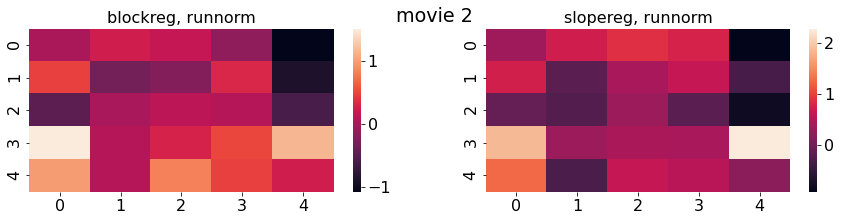

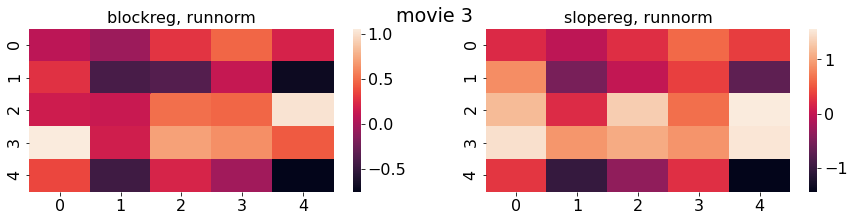

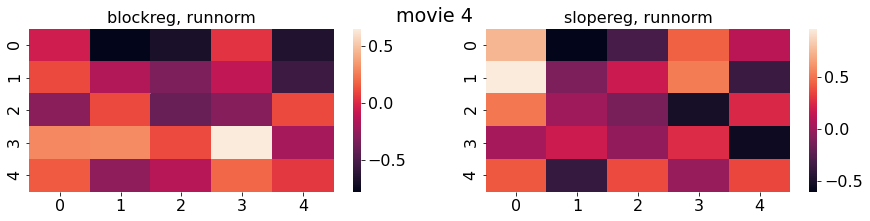

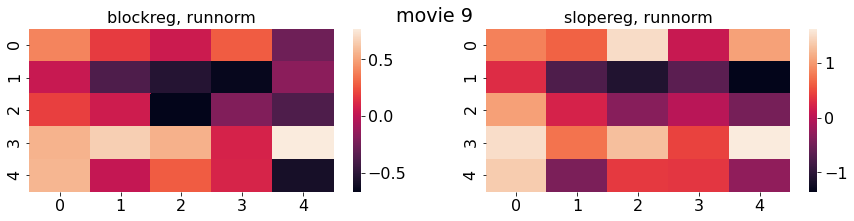

In [62]:
# sanity check: exploring results by plotting heatmaps for each movie (for a couple of subs and nodes)

for i,movie_ind in enumerate(movie_inds):
    plt.figure(i+1,figsize=(15,3))
    plt.suptitle(f'movie {movie_ind}')
    plt.subplot(121)
    plt.title('blockreg, runnorm')
    sns.heatmap(coef_blockreg_runnorm[:5,:5,i])
    plt.subplot(122)
    plt.title('slopereg, runnorm')
    sns.heatmap(coef_slopereg_runnorm[:5,:5,i])
    '''plt.subplot(143)
    plt.title('blockreg, trialnorm')
    sns.heatmap(coef_blockreg_trialnorm[:5,:5,i])
    plt.subplot(144)
    plt.title('slopereg, trialnorm')
    sns.heatmap(coef_slopereg_trialnorm[:5,:5,i])
    plt.tight_layout()
    plt.tight_layout()'''
    

looks okay so far

## Behavioral data analysis for the chosen movies

In [63]:
# load behavioral data - coded 1 for "social", 0 for "nonsocial" and 9 for "unsure", nan for missed response
responses = np.load(os.path.join(data_file_loc,'responses.npy'))
responses.shape # subs *movies

(1048, 10)

In [39]:
# rand mech - do "yes" responders to "rand" also respond more "yes"s in general?
other_inds = [0,1,2,3,5,6,7,8,9]
yes_responders = np.where(responses[:,4]==1)[0]
no_responders = np.where(responses[:,4]==0)[0]
tot_yes_responses_yesgrp = [len(np.where(responses[i,other_inds]==1)[0]) for i in yes_responders]
tot_yes_responses_nogrp =  [len(np.where(responses[i,other_inds]==1)[0]) for i in no_responders]
tot_yesno_responses_yesgrp = [len(np.where((responses[i,other_inds]==1)|(responses[i,other_inds]==0))[0]) for i in yes_responders]
tot_yesno_responses_nogrp =  [len(np.where((responses[i,other_inds]==1)|(responses[i,other_inds]==0))[0]) for i in no_responders]
fr_yes_responses =  np.divide(tot_yes_responses_yesgrp,tot_yesno_responses_yesgrp)
fr_no_responses = np.divide(tot_yes_responses_nogrp,tot_yesno_responses_nogrp)

Text(0.5, 1.0, '"No" responders for RANDMECH, for the other 9 movies')

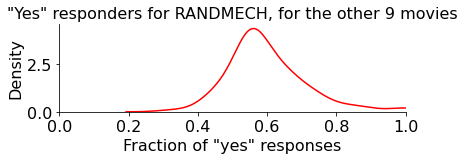

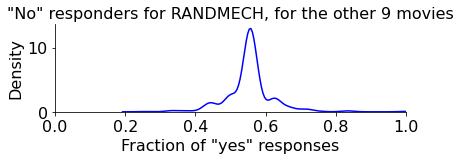

In [40]:
sns.displot(fr_yes_responses,alpha = .1,color = 'r',kind = 'kde', height=2,aspect = 3)
plt.xlim(0,1)
plt.xlabel('Fraction of "yes" responses')
plt.title('"Yes" responders for RANDMECH, for the other 9 movies')
sns.displot(fr_no_responses,alpha = .1,color = 'b',kind = 'kde', height=2,aspect = 3)
plt.xlim(0,1)
plt.xlabel('Fraction of "yes" responses')
plt.title('"No" responders for RANDMECH, for the other 9 movies')


In [41]:
print('mean diff=',np.nanmean(fr_yes_responses) - np.nanmean(fr_no_responses))
stats.ttest_ind(fr_yes_responses,fr_no_responses)

mean diff= 0.04601088919125551


Ttest_indResult(statistic=5.274186282285901, pvalue=1.7994841827389655e-07)

([<matplotlib.axis.XTick at 0x7fd929a74ad0>,
 [Text(1, 0, 'Yes'), Text(2, 0, 'No')])

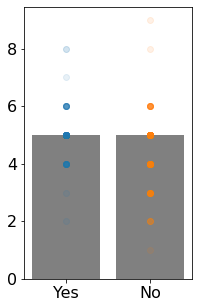

In [42]:
plt.figure(1,figsize=(3,5))
plt.plot(np.ones((len(tot_yes_responses_yesgrp),)),tot_yes_responses_yesgrp,ls= 'None',marker = 'o',alpha = .1)
plt.plot(2*np.ones((len(tot_yes_responses_nogrp),)),tot_yes_responses_nogrp,ls= 'None',marker = 'o',alpha = .1)
plt.bar([1,2],[np.nanmedian(tot_yes_responses_yesgrp),np.nanmedian(tot_yes_responses_nogrp)],color = 'grey')
plt.xticks([1,2],['Yes','No'])

In [13]:
print('11:',len(np.where((responses[:,3] == 1) & (responses[:,4] == 1))[0]))
print('10:',len(np.where((responses[:,3] == 1) & (responses[:,4] == 0))[0]))
print('01:',len(np.where((responses[:,3] == 0) & (responses[:,4] == 1))[0]))
print('00:',len(np.where((responses[:,3] == 0) & (responses[:,4] == 0))[0]))

subs = [np.where((responses[:,3] == 1) & (responses[:,4] == 1))[0],np.where((responses[:,3] == 1) & (responses[:,4] == 0))[0],
        np.where((responses[:,3] == 0) & (responses[:,4] == 1))[0],np.where((responses[:,3] == 0) & (responses[:,4] == 0))[0]]

11: 73
10: 490
01: 10
00: 42


In [14]:
# Load RT data
responses_rt = np.load(os.path.join(data_file_loc,'responses_rt.npy'))
responses_rt

array([[  nan, 2.7  , 2.278, ..., 1.606, 0.681, 1.23 ],
       [1.066, 1.035, 0.984, ..., 0.731, 1.536, 0.864],
       [0.913, 0.708, 0.511, ..., 0.334, 0.64 , 0.805],
       ...,
       [1.345, 1.561, 1.142, ..., 0.548, 0.994, 1.285],
       [0.719, 1.338, 0.544, ..., 0.777, 0.557, 0.468],
       [0.95 , 1.073, 1.085, ..., 1.426, 0.99 , 0.89 ]])

In [31]:
rts_ = [responses_rt[subs[i],3:5] for i in range(4)]
#rts_rand = [responses_rt[subs[i],4] for i in range(4)]


In [16]:
rts = []
movie = []
resptype_temp = ['FyesRYes','FYesRNo','FNoRYes','FNoRNo']
resptype = []
ids = []
for i in range(4):
    rts.extend(responses_rt[subs[i],3])
    movie.extend(np.repeat('FISHING',len(subs[i])))
    resptype.extend(np.repeat(resptype_temp[i],len(subs[i])))
    ids.extend(subs[i])
    rts.extend(responses_rt[subs[i],4])
    movie.extend(np.repeat('RANDMECH',len(subs[i])))
    resptype.extend(np.repeat(resptype_temp[i],len(subs[i])))
    ids.extend(subs[i])
    

In [17]:
df = pd.DataFrame({'ID':ids,'Movie':movie,'RespType': resptype,'RT':rts})
df.head()

ID    Movie  RespType     RT
0   11  FISHING  FyesRYes  0.856
1   21  FISHING  FyesRYes  0.455
2  129  FISHING  FyesRYes  0.776
3  141  FISHING  FyesRYes  0.876
4  165  FISHING  FyesRYes  1.134

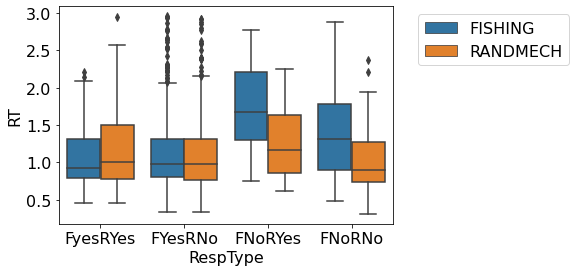

In [124]:
#sns.barplot(x='RespType',y='RT',hue='Movie',data = df)
sns.boxplot(x='RespType',y='RT',hue='Movie',data = df)
plt.legend(bbox_to_anchor = (1.05,1))

In [50]:
#pip install pingouin

In [18]:
import pingouin as pg
pg.mixed_anova(dv='RT', between='RespType', within='Movie', subject='ID', data=df)


Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0     RespType  3.645669    3  611  1.215223  4.187472  0.006004  0.020146   
1        Movie  0.418640    1  611  0.418640  2.032921  0.154435  0.003316   
2  Interaction  3.720726    3  611  1.240242  6.022632  0.000479  0.028722   

   eps  
0  NaN  
1  1.0  
2  NaN

In [24]:
pg.sphericity(data=df, dv='RT', subject='ID', within='Movie')[-1]


1.0

- sphericity assumption is met, since p > .05 above

In [22]:
pg.normality(df, dv='RT', group='Movie')

W          pval  normal
FISHING   0.867229  2.014272e-22   False
RANDMECH  0.890360  1.692758e-20   False

- normality assumption not met above

In [128]:
pg.homoscedasticity(df, dv='RT', group='RespType')

W      pval  equal_var
levene  2.974766  0.030712      False

-homoscedasticity assumption not met above

In [28]:
df.pairwise_tukey(dv='RT', between='RespType').round(3)

A         B  mean(A)  mean(B)   diff     se      T  p-tukey  hedges
0   FNoRNo   FNoRYes    1.190    1.531 -0.342  0.125 -2.742    0.031  -0.677
1   FNoRNo   FYesRNo    1.190    1.120  0.070  0.057  1.232    0.594   0.140
2   FNoRNo  FyesRYes    1.190    1.148  0.042  0.069  0.617    0.900   0.084
3  FNoRYes   FYesRNo    1.531    1.120  0.412  0.113  3.640    0.002   0.822
4  FNoRYes  FyesRYes    1.531    1.148  0.384  0.119  3.216    0.007   0.763
5  FYesRNo  FyesRYes    1.120    1.148 -0.028  0.044 -0.625    0.900  -0.055

In [34]:
rts_[0].shape

(73, 2)

In [36]:
for i in range(4):
    print(stats.ttest_rel(rts_[i][:,0],rts_[i][:,1]))

Ttest_relResult(statistic=-1.8749789075074432, pvalue=0.06485131050237362)
Ttest_relResult(statistic=1.118706102258192, pvalue=0.2638147827172071)
Ttest_relResult(statistic=1.4591840394523705, pvalue=0.17851627184556015)
Ttest_relResult(statistic=2.728212009534958, pvalue=0.009333718444291192)


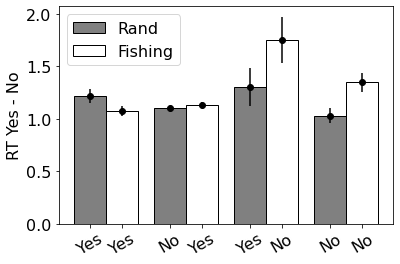

In [32]:
plt.errorbar(np.arange(4)-.2,[np.nanmean(rts_[i][:,1]) for i in range(4)], [stats.sem(rts_[i][:,1],nan_policy='omit') for i in range(4)],ls='None',color = 'k',marker = 'o')
plt.errorbar(np.arange(4)+.2,[np.nanmean(rts_[i][:,0]) for i in range(4)], [stats.sem(rts_[i][:,0],nan_policy='omit') for i in range(4)],ls='None',color = 'k',marker = 'o')
plt.bar(range(4),[np.nanmean(rts_[i][:,1]) for i in range(4)],color = 'grey',align='edge',width = -.4,edgecolor ='k',label = 'Rand')
plt.bar(range(4),[np.nanmean(rts_[i][:,0]) for i in range(4)],color = 'white',align='edge',width = .4,edgecolor ='k',label = 'Fishing')
plt.xticks([-.2,.8,1.8,2.8,.2,1.2,2.2,3.2],['Yes','No','Yes','No','Yes','Yes','No','No'],rotation=30)
plt.ylabel('RT Yes - No')
plt.legend()

Text(0, 0.5, 'RT Yes - No')

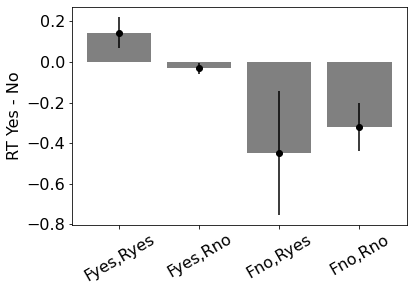

In [55]:
plt.errorbar(range(4),[np.nanmean(rts[i][:,1]-rts[i][:,0]) for i in range(4)], [stats.sem(rts[i][:,1]-rts[i][:,0],nan_policy='omit') for i in range(4)],
ls='None',color = 'k',marker = 'o')
plt.bar(range(4),[np.nanmean(rts[i][:,1]-rts[i][:,0]) for i in range(4)],color = 'grey')
plt.xticks(range(4),['Fyes,Ryes','Fyes,Rno','Fno,Ryes','Fno,Rno'],rotation=30)
plt.ylabel('RT Yes - No')

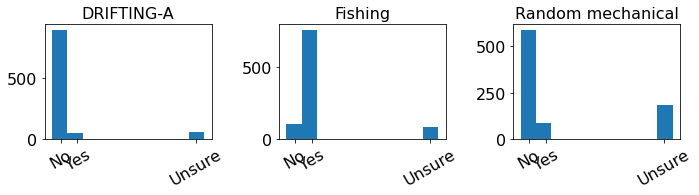

In [43]:
movie_inds = [2,3,4]
plt.figure(1,figsize=(10,3))
for i, movie_ind in enumerate(movie_inds):
    plt.subplot(1,len(movie_inds),i+1)
    plt.hist(responses[:,movie_ind])
    plt.xticks([0.5,1.5,8.5],['No','Yes','Unsure'],rotation =30)
    plt.title(vid_joined[movie_ind])
plt.tight_layout()

Missed responses: 0 , 0 sec

Unsure: 57 ,mean: 1.45 ,sem: 0.09 sec
Yes: 56 ,mean: 1.26 ,sem: 0.08 sec
No: 888 ,mean: 1.01 sem: 0.02 sec
Yes - No: Ttest_indResult(statistic=3.0924796780823978, pvalue=0.0030277787772658416)
Yes - Unsure: Ttest_indResult(statistic=-1.6731043391585303, pvalue=0.09713750231926163)
Missed responses: 0 , 0 sec

Unsure: 89 ,mean: 1.51 ,sem: 0.07 sec
Yes: 757 ,mean: 1.15 ,sem: 0.02 sec
No: 108 ,mean: 1.43 sem: 0.06 sec
Yes - No: Ttest_indResult(statistic=-4.407248971857992, pvalue=2.2070042850853976e-05)
Yes - Unsure: Ttest_indResult(statistic=-4.964430652733645, pvalue=2.849090306195764e-06)
Missed responses: 0 , 0 sec

Unsure: 186 ,mean: 1.4 ,sem: 0.04 sec
Yes: 88 ,mean: 1.22 ,sem: 0.06 sec
No: 587 ,mean: 1.1 sem: 0.02 sec
Yes - No: Ttest_indResult(statistic=1.751000488748883, pvalue=0.08281213604559506)
Yes - Unsure: Ttest_indResult(statistic=-2.4262943378439896, pvalue=0.01626289861248551)
Missed responses: 0 , 0 sec

Unsure: 122 ,mean: 1.11 ,sem: 0.04 sec


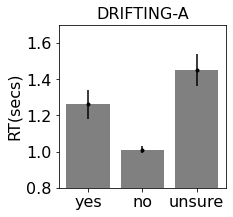

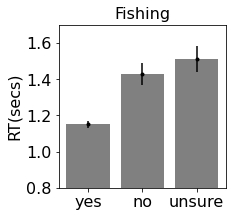

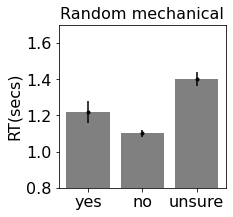

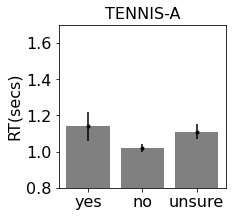

In [64]:
# quick look at behavioral stats 

for i,movie_ind in enumerate(movie_inds):
    print('Missed responses:', len(np.where(np.isnan(responses[:,movie_ind]==1))[0]), ',', len(np.where(np.isnan(responses_rt[:,movie_ind]==1))[0]),'sec')

    unsure_mean_se = [np.round(np.nanmean(responses_rt[responses[:,movie_ind]==9,movie_ind]),2),np.round(stats.sem(responses_rt[responses[:,movie_ind]==9,movie_ind],nan_policy='omit'),2)]
    print('\nUnsure:', len(np.where(responses[:,movie_ind]==9)[0]), ',mean:', unsure_mean_se[0], ',sem:', unsure_mean_se[1],'sec')

    yes_mean_se = [np.round(np.nanmean(responses_rt[responses[:,movie_ind]==1,movie_ind]),2),np.round(stats.sem(responses_rt[responses[:,movie_ind]==1,movie_ind],nan_policy='omit'),2)]
    print('Yes:', len(np.where(responses[:,movie_ind]==1)[0]), ',mean:', yes_mean_se[0], ',sem:', yes_mean_se[1],'sec')

    no_mean_se = [np.round(np.nanmean(responses_rt[responses[:,movie_ind]==0,movie_ind]),2),np.round(stats.sem(responses_rt[responses[:,movie_ind]==0,movie_ind],nan_policy='omit'),2)]
    print('No:',  len(np.where(responses[:,movie_ind]==0)[0]), ',mean:', no_mean_se[0], 'sem:',  no_mean_se[1],'sec')

    print('Yes - No:',stats.ttest_ind(responses_rt[responses[:,movie_ind]==1,movie_ind],responses_rt[responses[:,movie_ind]==0,movie_ind],nan_policy='omit',equal_var=False))
    print('Yes - Unsure:',stats.ttest_ind(responses_rt[responses[:,movie_ind]==1,movie_ind],responses_rt[responses[:,movie_ind]==9,movie_ind],nan_policy='omit',equal_var=False))

    plt.figure(i+1,figsize=(3,3))
    plt.bar(range(3),[yes_mean_se[0],no_mean_se[0],unsure_mean_se[0]],color = 'grey')
    plt.errorbar(range(3),[yes_mean_se[0],no_mean_se[0],unsure_mean_se[0]],[yes_mean_se[1],no_mean_se[1],unsure_mean_se[1]],ls = 'None',marker = '.',color = 'k')
    plt.xticks(range(3),['yes','no','unsure'])
    plt.ylabel('RT(secs)')
    plt.ylim(.8,1.7)
    plt.title(vid_joined[movie_ind])
    


# compare estimates
## within-movie,between subject comparison, using runwise normalized data

In [66]:
from mne.stats import fdr_correction

In [68]:
# comparing regressor coeffts across yes and no responders for the three most ambiguous movies (1 analysis per node and movie)

movie_inds = [2,3,4,9]
nnodes = 268
nmovies = 10
pval_block = np.empty((nnodes,len(movie_inds)))
meanDiff_bl = np.empty_like(pval_block)
pval_slope = np.empty_like(pval_block)
meanDiff_sl = np.empty_like(pval_block)
pval_block[:] = np.nan
meanDiff_bl[:] = np.nan
pval_slope[:] = np.nan
meanDiff_sl[:] = np.nan

for i, movie_ind in enumerate(movie_inds):

    soc_inds = responses[:,movie_ind]==1 # subs who responded "social"
    nonsoc_inds = responses[:,movie_ind]==0 # subs who respoded "nonsocial"

    print(f'movie={vid_joined[movie_ind]},soc={len(np.where(soc_inds)[0])},nonsocial={len(np.where(nonsoc_inds)[0])}')

    _,pval_block[:,i] = stats.ttest_ind(coef_blockreg_runnorm[soc_inds,:,i], coef_blockreg_runnorm[nonsoc_inds,:,i],axis=0, equal_var=False)
    meanDiff_bl[:,i] = np.nanmean(coef_blockreg_runnorm[soc_inds,:,i],axis=0) - np.nanmean(coef_blockreg_runnorm[nonsoc_inds,:,i],axis=0)

    # ttest between slope regs yes vs. no
    _,pval_slope[:,i] = stats.ttest_ind(coef_slopereg_runnorm[soc_inds,:,i], coef_slopereg_runnorm[nonsoc_inds,:,i],axis=0, equal_var=False)
    meanDiff_sl[:,i] = np.nanmean(coef_slopereg_runnorm[soc_inds,:,i],axis=0)-np.nanmean(coef_slopereg_runnorm[nonsoc_inds,:,i],axis=0)

    #fdr correction
    _,pval_block[:,i] = fdr_correction(pval_block[:,i],.05)
    _,pval_slope[:,i] = fdr_correction(pval_slope[:,i],.05)


movie=DRIFTING-A,soc=56,nonsocial=888
movie=Fishing,soc=757,nonsocial=108
movie=Random mechanical,soc=88,nonsocial=587
movie=TENNIS-A,soc=47,nonsocial=806


## within-subject, between movies using trialwise normalized data

In [52]:
# coax vs bill
movie_inds = [0,1]
nnodes = 268
nmovies = 10
'''pval_block_paired = np.empty((nnodes,))
meanDiff_bl_paired = np.empty_like(pval_block)
pval_slope_paired = np.empty_like(pval_block)
meanDiff_sl_paired = np.empty_like(pval_block)
pval_block_paired[:] = np.nan
meanDiff_bl_paired[:] = np.nan
pval_slope_paired[:] = np.nan
meanDiff_sl_paired[:] = np.nan'''

print([vid_joined[i] for i in movie_inds])

subs = (responses[:,movie_inds[0]]==1) & (responses[:,movie_inds[1]]==0) # subs who respoded "nonsocial" to BILL and "social" to COAX

_,pval_block_paired = stats.ttest_rel(coef_blockreg_trialnorm[subs,:,movie_inds[0]], coef_blockreg_trialnorm[subs,:,movie_inds[1]],axis=0)
meanDiff_bl_paired = np.nanmean(coef_blockreg_trialnorm[subs,:,movie_inds[0]]-coef_blockreg_trialnorm[subs,:,movie_inds[1]],axis=0)

# ttest between slope regs yes vs. no
_,pval_slope_paired = stats.ttest_rel(coef_slopereg_trialnorm[subs,:,movie_inds[0]], coef_slopereg_trialnorm[subs,:,movie_inds[1]],axis=0)
meanDiff_sl_paired = np.nanmean(coef_slopereg_trialnorm[subs,:,movie_inds[0]]-coef_slopereg_trialnorm[subs,:,movie_inds[1]],axis=0)

#fdr correction
_,pval_block_paired = fdr_correction(pval_block_paired,.05)
_,pval_slope_paired = fdr_correction(pval_slope_paired,.05)


['COAXING-B', 'BILLIARD-A']


# Plot results

 - The mean differences between regression coeffts for social and nonsocial responses overlaid on brainmaps. Separate figures for (1) block regressors and (2) slope regressors and for the same and different movies

In [69]:
# functions to plot brain maps
#from nilearn.plotting import plot_glass_brain
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain   
from nilearn.plotting import plot_glass_brain
mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)     

In [70]:
# load shen atlas labels
pd.set_option('display.max_colwidth', None) # so columns are not snipped
shen268 = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
#shen268.head()


## Block/slope regressor, same movie

DRIFTING-A,block reg: 1 ROIs sig. at p-value threshold .05

DRIFTING-A,slope reg: 0 ROIs sig. at p-value threshold .05

Fishing,block reg: 0 ROIs sig. at p-value threshold .05

Fishing,slope reg: 1 ROIs sig. at p-value threshold .05

Random mechanical,block reg: 18 ROIs sig. at p-value threshold .05

Random mechanical,slope reg: 117 ROIs sig. at p-value threshold .05

TENNIS-A,block reg: 0 ROIs sig. at p-value threshold .05

TENNIS-A,slope reg: 16 ROIs sig. at p-value threshold .05



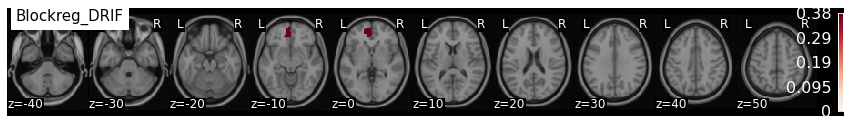

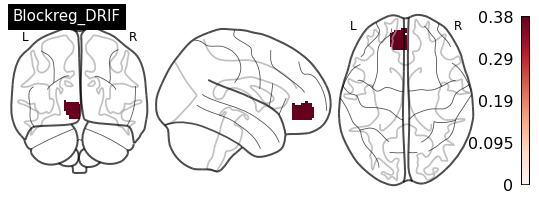

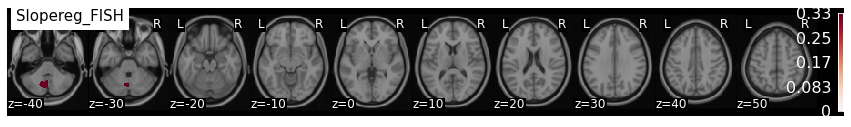

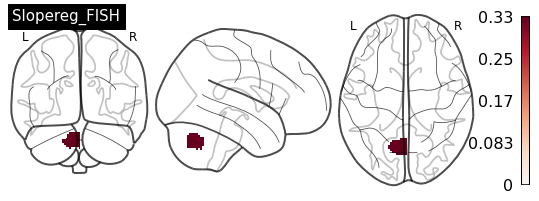

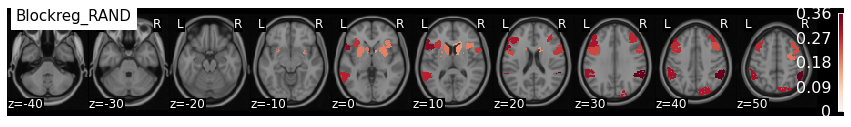

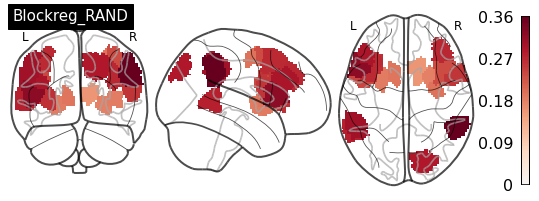

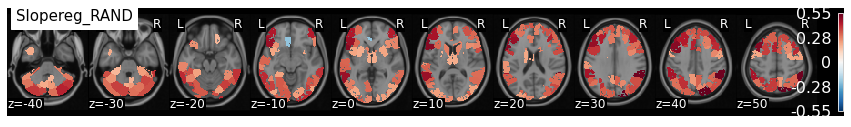

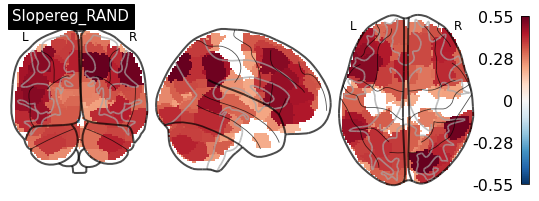

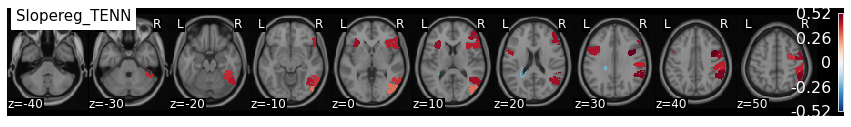

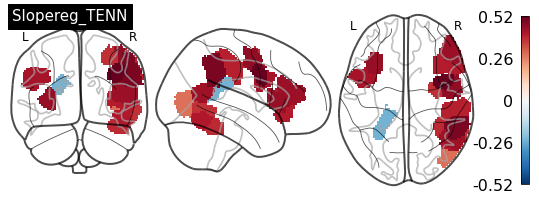

In [71]:
# plotting social vs. nonsocial, block and slope regressor

nodes_block = np.zeros((268,len(movie_inds)))
nodes_slope = np.zeros((268,len(movie_inds)))
        
movie_inds = [2,3,4,9]
for i, movie_ind in enumerate(movie_inds):
    if len(np.where(pval_block[:,i]<.05)[0]) >0: 
        nodes_block[pval_block[:,i]<.05,i] = meanDiff_bl[pval_block[:,i]<.05,i]
        img = roi_to_brain(pd.Series(nodes_block[:,i]), mask_x)
        txt = 'Blockreg_' + str.upper(vid_joined[movie_ind][:4])
        img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
        plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs=False, title=txt,cmap = 'RdBu_r')
        img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

    rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_block[:,i]<.05)[0]]
    print(f'{vid_joined[movie_ind]},block reg: {len(rois)} ROIs sig. at p-value threshold .05\n')


    if len(np.where(pval_slope[:,i]<.05)[0]) >0: 
        nodes_slope[pval_slope[:,i]<.05,i] = meanDiff_sl[pval_slope[:,i]<.05,i]
        img = roi_to_brain(pd.Series(nodes_slope[:,i]), mask_x)
        txt = 'Slopereg_' + str.upper(vid_joined[movie_ind][:4])
        img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
        plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs=False, title = txt,cmap = 'RdBu_r')
        img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

    rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_slope[:,i]<.05)[0]]
    print(f'{vid_joined[movie_ind]},slope reg: {len(rois)} ROIs sig. at p-value threshold .05\n')


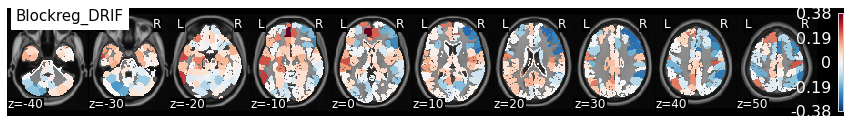

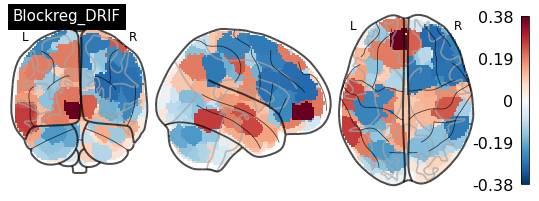

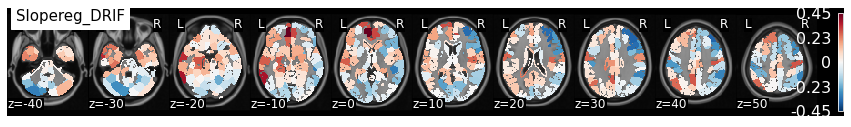

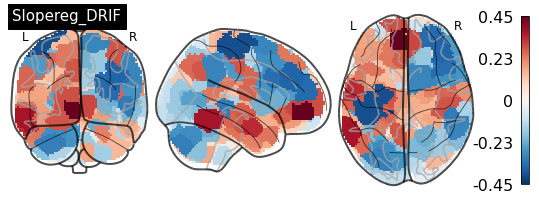

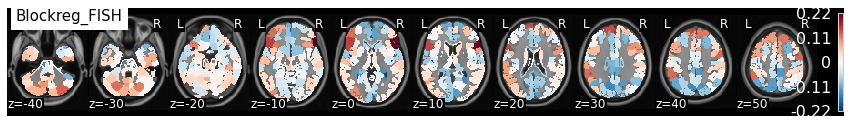

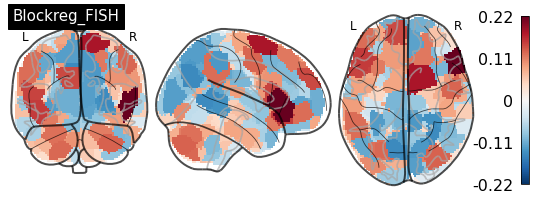

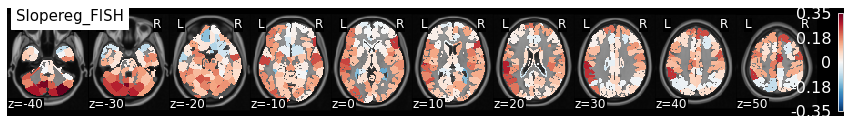

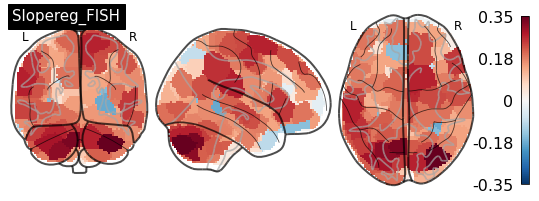

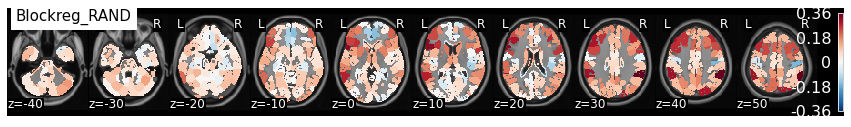

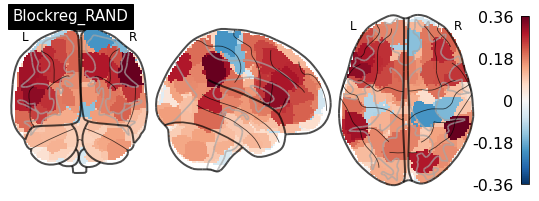

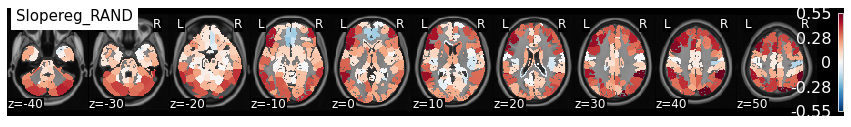

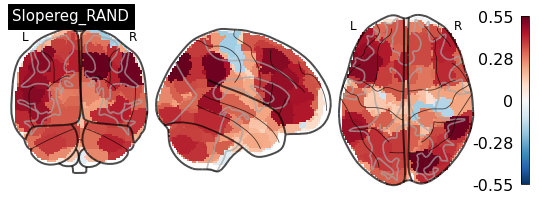

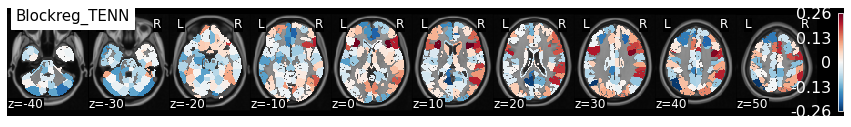

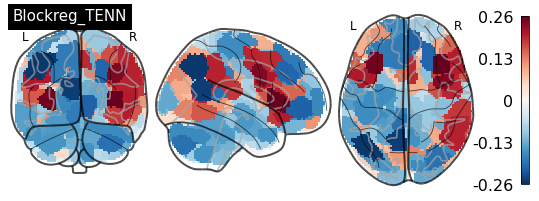

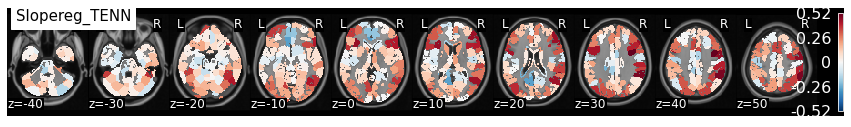

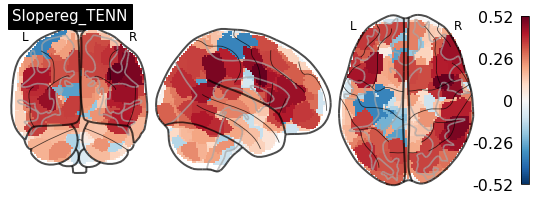

In [72]:
# unthresholded Fishing/randmech

# plotting social vs. nonsocial, block and slope regressor

nodes_block = np.zeros((268,len(movie_inds)))
nodes_slope = np.zeros((268,len(movie_inds)))
        
movie_inds = [2,3,4,9]
for i, movie_ind in enumerate(movie_inds):
    #if len(np.where(pval_block[:,i]<.05)[0]) >0: 
        #nodes_block[pval_block[:,i]<.05,i] = meanDiff_bl[pval_block[:,i]<.05,i]
    img = roi_to_brain(pd.Series(meanDiff_bl[:,i]), mask_x)
    txt = 'Blockreg_' + str.upper(vid_joined[movie_ind][:4])
    img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
    plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs=False, title=txt,cmap = 'RdBu_r')
    #img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

    #rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_block[:,i]<.05)[0]]
    #print(f'{vid_joined[movie_ind]},block reg: {len(rois)} ROIs sig. at p-value threshold .05\n')


    #if len(np.where(pval_slope[:,i]<.05)[0]) >0: 
        #nodes_slope[pval_slope[:,i]<.05,i] = meanDiff_sl[pval_slope[:,i]<.05,i]
    img = roi_to_brain(pd.Series(meanDiff_sl[:,i]), mask_x)
    txt = 'Slopereg_' + str.upper(vid_joined[movie_ind][:4])
    img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
    plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs=False, title = txt,cmap = 'RdBu_r')
    #img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

    #rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_slope[:,i]<.05)[0]]
    #print(f'{vid_joined[movie_ind]},slope reg: {len(rois)} ROIs sig. at p-value threshold .05\n')


Looks like no Fishing node is significant. Sanity check below by plotting timecourses.

# COAX v. BILL

Random mechanical,block reg: 212 ROIs sig. at p-value threshold .05

Random mechanical,slope reg: 215 ROIs sig. at p-value threshold .05



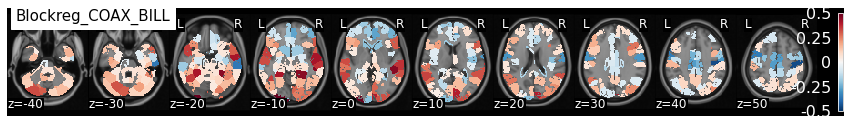

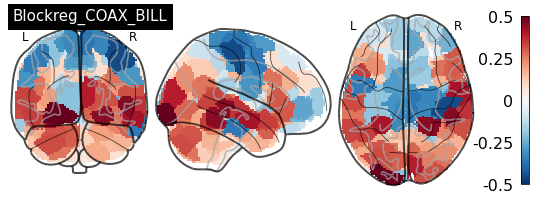

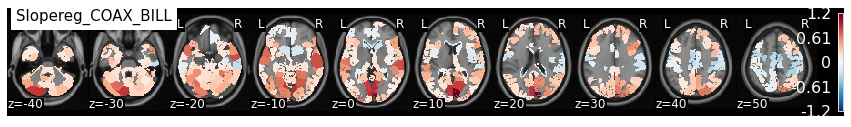

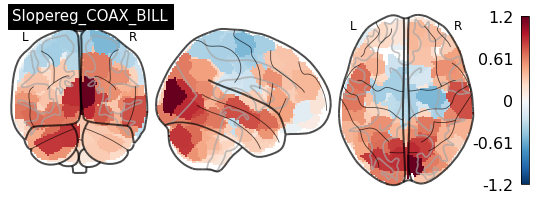

In [44]:
# plotting social vs. nonsocial, block and slope regressor

nodes_block = np.zeros((268,))
nodes_slope = np.zeros((268,))
        
if len(np.where(pval_block_paired<.05)[0]) >0: 
    nodes_block[pval_block_paired<.05] = meanDiff_bl_paired[pval_block_paired<.05]
    img = roi_to_brain(pd.Series(nodes_block), mask_x)
    txt = 'Blockreg_COAX_BILL'
    img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
    plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs=False, title=txt,cmap = 'RdBu_r')
    img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_block_paired<.05)[0]]
print(f'{vid_joined[movie_ind]},block reg: {len(rois)} ROIs sig. at p-value threshold .05\n')


if len(np.where(pval_slope_paired<.05)[0]) >0: 
    nodes_slope[pval_slope_paired<.05] = meanDiff_sl_paired[pval_slope_paired<.05]
    img = roi_to_brain(pd.Series(nodes_slope), mask_x)
    txt = 'Slopereg_COAX_BILL'
    img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
    plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs=False, title = txt,cmap = 'RdBu_r')
    img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_slope_paired<.05)[0]]
print(f'{vid_joined[movie_ind]},slope reg: {len(rois)} ROIs sig. at p-value threshold .05\n')


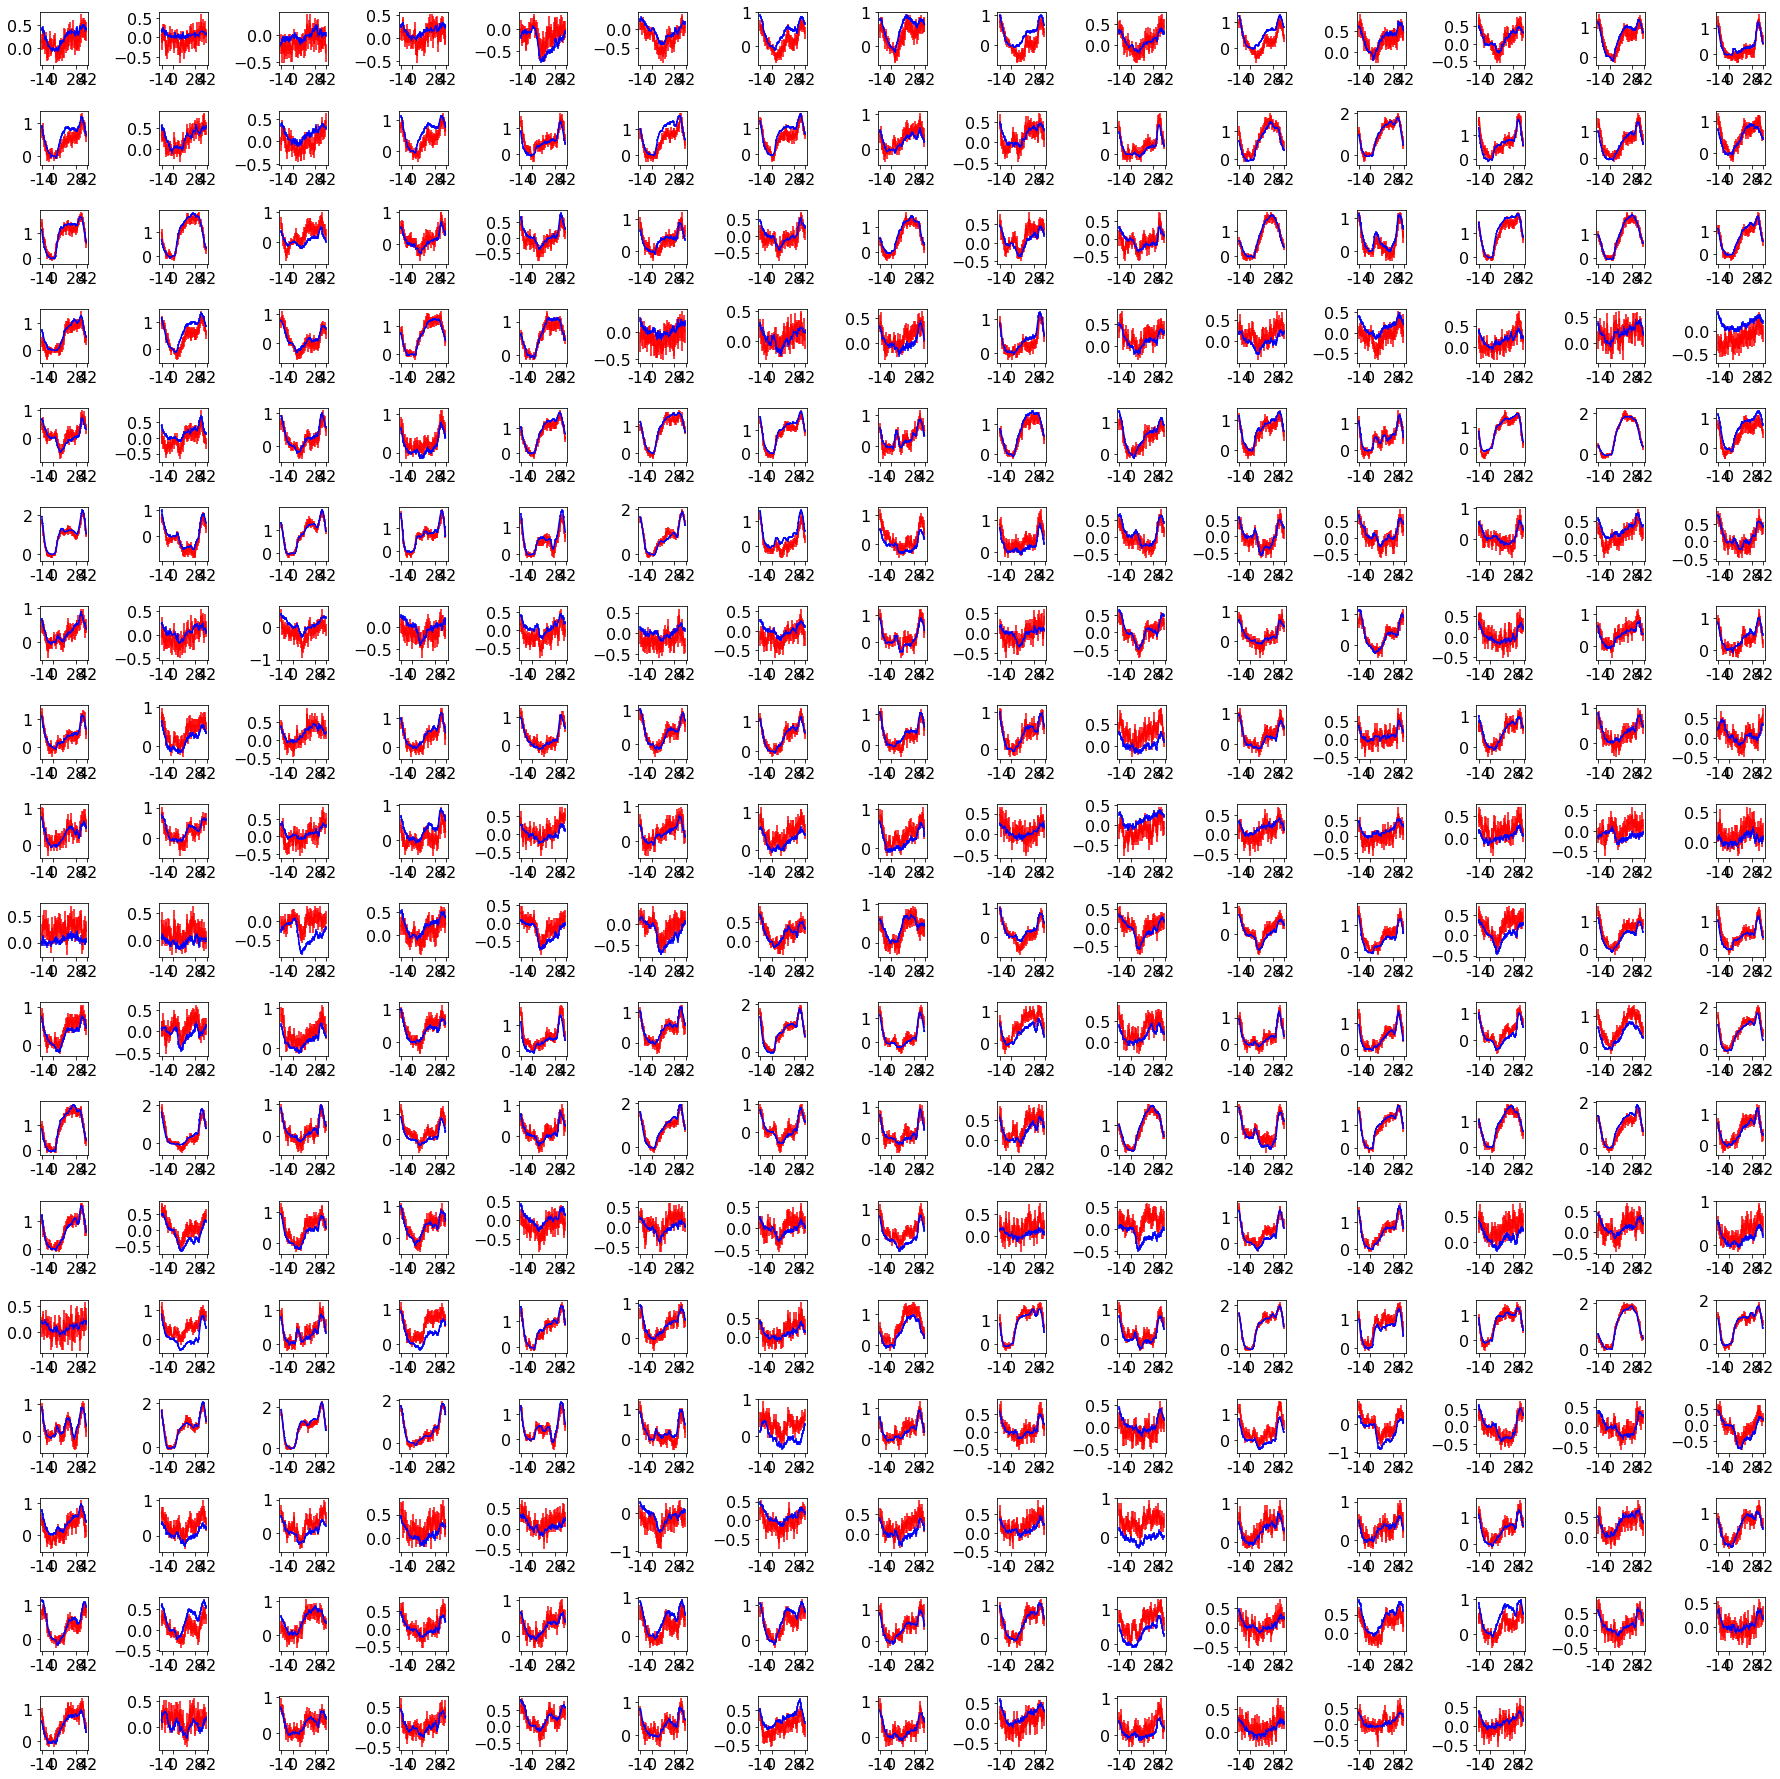

In [126]:
movie_ind = 2
plt.figure(1,figsize = (25,25))
for n in range(268):
    plt.subplot(18,15,n+1)
    plt.errorbar(range(tcs_run_z.shape[2]), np.nanmean(tcs_run_z[responses[:,movie_ind]==1,n,:,movie_ind],axis=0), 
    stats.sem(tcs_run_z[responses[:,movie_ind]==1,n,:,movie_ind],axis=0),color = 'r')
    plt.errorbar(range(tcs_run_z.shape[2]), np.nanmean(tcs_run_z[responses[:,movie_ind]==0,n,:,movie_ind],axis=0), 
    stats.sem(tcs_run_z[responses[:,movie_ind]==0,n,:,movie_ind],axis=0),color = 'b')
    plt.xticks([0,vid_start_rel_tr[movie_ind],vid_start_rel_tr[movie_ind]+l_task,tcs_run_z.shape[2]],[str(i) for i in [-vid_start_rel_tr[movie_ind],0,l_task,tcs_run_z.shape[2]-vid_start_rel_tr[movie_ind]]])
plt.tight_layout()


DRIFTING-A : SpearmanrResult(correlation=0.9289154245480338, pvalue=8.987444828405606e-117)
 
1.248 x + 0.009529
Fishing : SpearmanrResult(correlation=0.7440118649889933, pvalue=1.7199942091382674e-48)
 
1.088 x + 0.08957
Random mechanical : SpearmanrResult(correlation=0.8321133981734947, pvalue=4.6557259967604594e-70)
 
1.438 x + 0.07103
TENNIS-A : SpearmanrResult(correlation=0.831845949651101, pvalue=5.644625661346584e-70)
 
1.496 x + 0.1249


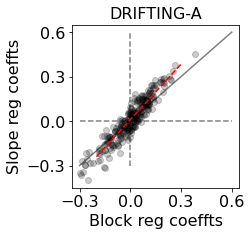

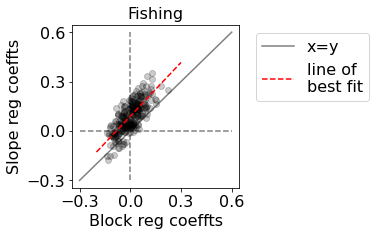

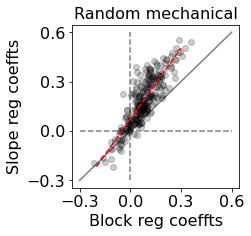

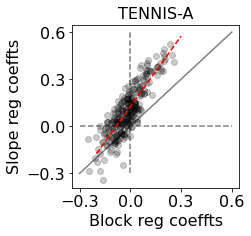

In [73]:
for i,movie_ind in enumerate(movie_inds):
    plt.figure(i+1,figsize=(3,3))
    plt.plot(np.linspace(-.3,.6,5),np.linspace(-.3,.6,5),color = 'grey',label = 'x=y')
    plt.vlines(0,-.3,.6,color = 'grey',ls = 'dashed')
    plt.hlines(0,-.3,.6,color = 'grey',ls = 'dashed')
    plt.plot(meanDiff_bl[:,i],meanDiff_sl[:,i],ls = 'None',color = 'k',marker = 'o',alpha = .2)
    plt.xlabel('Block reg coeffts')
    plt.ylabel('Slope reg coeffts')
    plt.xticks(np.linspace(-.3,.6,4))
    plt.yticks(np.linspace(-.3,.6,4))
    stats.spearmanr(meanDiff_bl[:,i],meanDiff_sl[:,i])
    print(vid_joined[movie_ind],':',stats.spearmanr(meanDiff_bl[:,i],meanDiff_sl[:,i]))
    plt.title(vid_joined[movie_ind])

    m, b = np.polyfit(meanDiff_bl[:,i],meanDiff_sl[:,i], 1)
    print(np.poly1d([m,b]))
    xplot = np.linspace(-.2,.3,10)
    plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')

    if i == 1:
        plt.legend(bbox_to_anchor = (1.05,1))



DRIFTING-A : SpearmanrResult(correlation=0.8268934763133499, pvalue=1.881225905658528e-68)
 
1.418 x + 0.1108


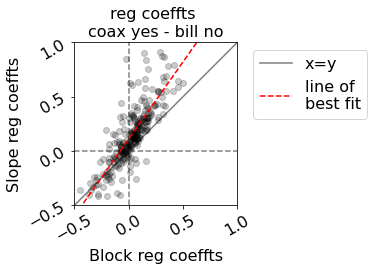

In [228]:
# across movies, coax and fish

fig = plt.figure(i+1,figsize=(6,3))
ax = fig.add_subplot(111)
(axmin,axmax) = (-.5,1)
plt.xlim(axmin,axmax)
plt.ylim(axmin,axmax)

plt.plot(np.linspace(axmin,axmax,5),np.linspace(axmin,axmax,5),color = 'grey',label = 'x=y')
plt.vlines(0,axmin,axmax,color = 'grey',ls = 'dashed')
plt.hlines(0,axmin,axmax,color = 'grey',ls = 'dashed')
plt.plot(meanDiff_bl_paired,meanDiff_sl_paired,ls = 'None',color = 'k',marker = 'o',alpha = .2)
plt.xlabel('Block reg coeffts')
plt.ylabel('Slope reg coeffts')
plt.xticks(np.linspace(axmin,axmax,4),rotation=30)
plt.yticks(np.linspace(axmin,axmax,4),rotation=30)
stats.spearmanr(meanDiff_bl_paired,meanDiff_sl_paired)
print(vid_joined[movie_ind],':',stats.spearmanr(meanDiff_bl_paired,meanDiff_sl_paired))
plt.title('reg coeffts \ncoax yes - bill no')

m, b = np.polyfit(meanDiff_bl_paired,meanDiff_sl_paired, 1)
print(np.poly1d([m,b]))
xplot = np.linspace(axmin,axmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')

ax.set_aspect('equal')

plt.legend(bbox_to_anchor = (1.05,1))



In [166]:
nodes_coaxbill_rand = (pval_slope_paired<.05) & (pval_slope[:,2]<.05) & (np.sign(meanDiff_sl_paired) == np.sign(meanDiff_sl[:,2]))
np.where(nodes_coaxbill_rand)[0].shape

(86,)

Random mechanical : SpearmanrResult(correlation=0.42561034682898935, pvalue=3.2331627884076993e-13)
 
0.2094 x + 0.1483
 
0.0901 x + 0.2869


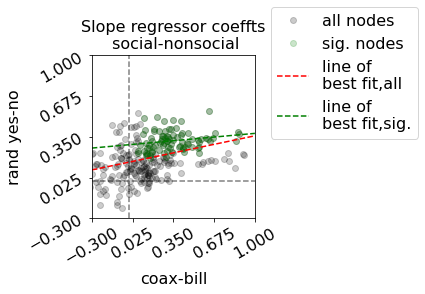

In [230]:
# across movies, coax and fish

fig = plt.figure(i+1,figsize=(4,3))
ax = fig.add_subplot(111)
(axmin,axmax) = (-.3,1)
#plt.plot(np.linspace(axmin,axmax,5),np.linspace(axmin,axmax,5),color = 'grey',label = 'x=y')
plt.xlim(axmin,axmax)
plt.ylim(axmin,axmax)

plt.vlines(0,axmin,axmax,color = 'grey',ls = 'dashed')
plt.hlines(0,axmin,axmax,color = 'grey',ls = 'dashed')
plt.plot(meanDiff_sl_paired, meanDiff_sl[:,2],ls = 'None',color = 'k',marker = 'o',alpha = .2, label = 'all nodes')
plt.plot(meanDiff_sl_paired[nodes_coaxbill_rand],meanDiff_sl[nodes_coaxbill_rand,2],ls = 'None',color = 'g',\
    marker = 'o',alpha = .2,label = 'sig. nodes')
plt.xlabel('coax-bill')
plt.ylabel('rand yes-no')
plt.xticks(np.linspace(axmin,axmax,5),rotation=30)
plt.yticks(np.linspace(axmin,axmax,5),rotation=30)
#stats.spearmanr(meanDiff_bl[:,i],meanDiff_sl[:,i])
print(vid_joined[4],':',stats.spearmanr(meanDiff_sl_paired, meanDiff_sl[:,2]))
plt.title('Slope regressor coeffts\n social-nonsocial')

m, b = np.polyfit(meanDiff_sl_paired, meanDiff_sl[:,2], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(axmin,axmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit,all')

m, b = np.polyfit(meanDiff_sl_paired[nodes_coaxbill_rand], meanDiff_sl[nodes_coaxbill_rand,2], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(axmin,axmax,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'g',label = 'line of \nbest fit,sig.')

ax.set_aspect('equal')

plt.legend(bbox_to_anchor = (1.05,.44))

#plt.tight_layout()

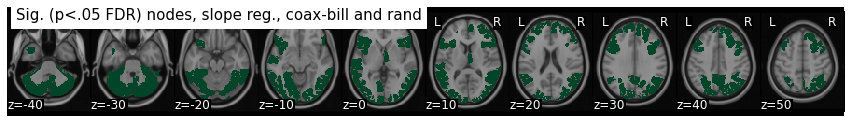

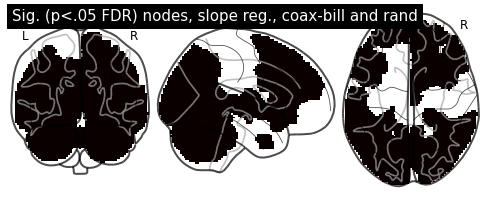

In [168]:
nodes = np.zeros((268,))
nodes[nodes_coaxbill_rand] = 1
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = 'Sig. (p<.05 FDR) nodes, slope reg., coax-bill and rand'
img.plot(title = txt,cmap='YlGn')
plot_glass_brain(img.to_nifti(), title=txt)



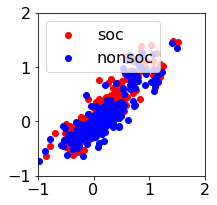

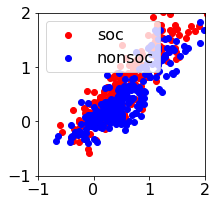

In [241]:
plt.figure(1,figsize = (3,3))
plt.scatter(np.nanmean(coef_blockreg_runnorm[soc_inds,:,0],axis=0),   np.nanmean(coef_blockreg_runnorm[soc_inds,:,1],axis=0), label = 'soc',color = 'r')
plt.scatter(np.nanmean(coef_blockreg_runnorm[nonsoc_inds,:,0],axis=0),np.nanmean(coef_blockreg_runnorm[nonsoc_inds,:,1],axis=0),label = 'nonsoc',color = 'b')
plt.legend()
plt.xlim(-1,2)
plt.ylim(-1,2)

plt.figure(2,figsize = (3,3))
plt.scatter(np.nanmean(coef_slopereg_runnorm[soc_inds,:,0],axis=0),   np.nanmean(coef_slopereg_runnorm[soc_inds,:,1],axis=0),label = 'soc',color = 'r')
plt.scatter(np.nanmean(coef_slopereg_runnorm[nonsoc_inds,:,0],axis=0),np.nanmean(coef_slopereg_runnorm[nonsoc_inds,:,1],axis=0),label = 'nonsoc',color = 'b')
plt.xlim(-1,2)
plt.ylim(-1,2)
plt.legend()

From the above figures, it looks like the mean estimate for both yes and no responses correlate. but is this response-selective or general?

For this, a control analysis, plotting social-fishing and nonsocial-rand, and nonsocial-fishing and social-rand

(-1.0, 2.0)

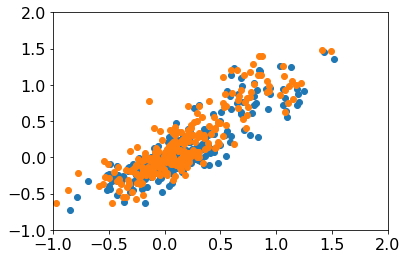

In [242]:
plt.scatter(np.nanmean(coef_blockreg_runnorm[soc_inds,:,0],axis=0),   np.nanmean(coef_blockreg_runnorm[nonsoc_inds,:,1],axis=0))
plt.scatter(np.nanmean(coef_blockreg_runnorm[nonsoc_inds,:,0],axis=0),np.nanmean(coef_blockreg_runnorm[soc_inds,:,1],axis=0))
plt.xlim(-1,2)
plt.ylim(-1,2)


This also looks like it could potentially correlate well.  thus, what we saw with the (non)social fish and (non)social rand could just be general stimulus responsiveness of nodes. 

Maybe it's more meaningful to compare social-nonsocial for each movie. This is done below:

 
0.4057 x + 0.07605
block: (0.2928628450962992, 1.064285643231501e-06)
 
0.4363 x + 0.1413
slope: (0.27245660970355423, 6.029220752773722e-06)


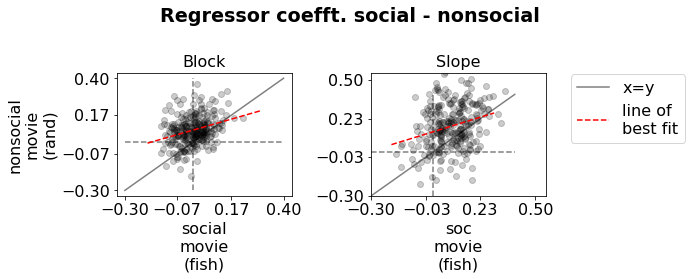

In [73]:
plt.figure(1,figsize=(10,4))
plt.suptitle('Regressor coefft. social - nonsocial',weight='bold')

plt.subplot(1,2,1)
plt.plot(np.linspace(-.3,.4,5),np.linspace(-.3,.4,5),color = 'grey')
plt.vlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.hlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.plot(meanDiff_bl[:,1],meanDiff_bl[:,2],ls = 'None',color = 'k',marker = 'o',alpha=.2)
plt.xlabel('social\nmovie\n(fish)')
plt.ylabel('nonsocial\nmovie\n(rand)')
plt.xticks([np.round(i,2) for i in np.linspace(-.3,.4,4)])
plt.yticks([np.round(i,2) for i in np.linspace(-.3,.4,4)])
stats.spearmanr(meanDiff_bl[:,1],meanDiff_bl[:,2])
m, b = np.polyfit(meanDiff_bl[:,1],meanDiff_bl[:,2], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(-.2,.3,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r')
print('block:',stats.pearsonr(meanDiff_bl[:,1],meanDiff_bl[:,2]))
plt.title('Block')


plt.subplot(1,2,2)
plt.plot(np.linspace(-.3,.4,5),np.linspace(-.3,.4,5),color = 'grey',label = 'x=y')
plt.vlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.hlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.plot(meanDiff_sl[:,1],meanDiff_sl[:,2],ls = 'None',color = 'k',marker = 'o',alpha=.2)
plt.xlabel('soc\nmovie\n(fish)')
plt.xticks([np.round(i,2) for i in np.linspace(-.3,.5,4)])
plt.yticks([np.round(i,2) for i in np.linspace(-.3,.5,4)])
stats.spearmanr(meanDiff_sl[:,1],meanDiff_sl[:,2])
m, b = np.polyfit(meanDiff_sl[:,1],meanDiff_sl[:,2], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(-.2,.3,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
print('slope:',stats.pearsonr(meanDiff_sl[:,1],meanDiff_sl[:,2]))
plt.title('Slope')
plt.xlim(-.3,.55)
plt.ylim(-.3,.55)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()

 
-0.2805 x + 0.07684
block: (-0.34388382164036024, 7.445321205235997e-09)
 
-0.3545 x + 0.1851
slope: (-0.3466246102035673, 5.5528705065013834e-09)


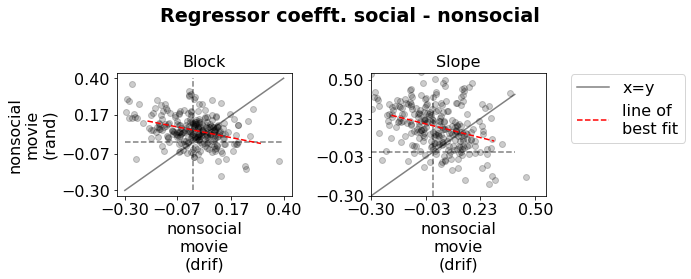

In [77]:
plt.figure(1,figsize=(10,4))
plt.suptitle('Regressor coefft. social - nonsocial',weight='bold')

plt.subplot(1,2,1)
plt.plot(np.linspace(-.3,.4,5),np.linspace(-.3,.4,5),color = 'grey')
plt.vlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.hlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.plot(meanDiff_bl[:,0],meanDiff_bl[:,2],ls = 'None',color = 'k',marker = 'o',alpha=.2)
plt.xlabel('nonsocial\nmovie\n(drif)')
plt.ylabel('nonsocial\nmovie\n(rand)')
plt.xticks([np.round(i,2) for i in np.linspace(-.3,.4,4)])
plt.yticks([np.round(i,2) for i in np.linspace(-.3,.4,4)])
stats.spearmanr(meanDiff_bl[:,0],meanDiff_bl[:,2])
m, b = np.polyfit(meanDiff_bl[:,0],meanDiff_bl[:,2], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(-.2,.3,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r')
print('block:',stats.pearsonr(meanDiff_bl[:,0],meanDiff_bl[:,2]))
plt.title('Block')


plt.subplot(1,2,2)
plt.plot(np.linspace(-.3,.4,5),np.linspace(-.3,.4,5),color = 'grey',label = 'x=y')
plt.vlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.hlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.plot(meanDiff_sl[:,0],meanDiff_sl[:,2],ls = 'None',color = 'k',marker = 'o',alpha=.2)
plt.xlabel('nonsocial\nmovie\n(drif)')
plt.xticks([np.round(i,2) for i in np.linspace(-.3,.5,4)])
plt.yticks([np.round(i,2) for i in np.linspace(-.3,.5,4)])
stats.spearmanr(meanDiff_sl[:,0],meanDiff_sl[:,2])
m, b = np.polyfit(meanDiff_sl[:,0],meanDiff_sl[:,2], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(-.2,.3,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
print('slope:',stats.pearsonr(meanDiff_sl[:,0],meanDiff_sl[:,2]))
plt.title('Slope')
plt.xlim(-.3,.55)
plt.ylim(-.3,.55)
plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.tight_layout()

In [74]:
meanDiff_bl.shape

(268, 4)

 
0.3982 x + 0.08257
block: (0.4015614868998575, 8.323316609793192e-12)
 
0.5841 x + 0.1219
slope: (0.6158001827928059, 2.2840032342335106e-29)


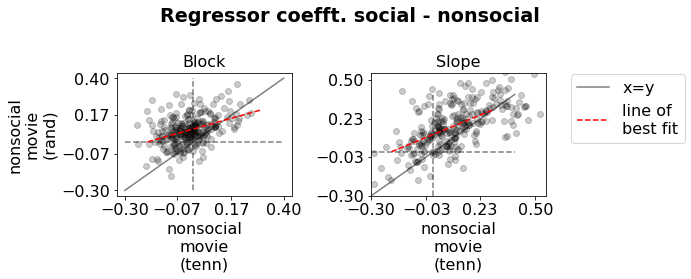

In [76]:
#tennis
plt.figure(1,figsize=(10,4))
plt.suptitle('Regressor coefft. social - nonsocial',weight='bold')

plt.subplot(1,2,1)
plt.plot(np.linspace(-.3,.4,5),np.linspace(-.3,.4,5),color = 'grey')
plt.vlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.hlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.plot(meanDiff_bl[:,-1],meanDiff_bl[:,2],ls = 'None',color = 'k',marker = 'o',alpha=.2)
plt.xlabel('nonsocial\nmovie\n(tenn)')
plt.ylabel('nonsocial\nmovie\n(rand)')
plt.xticks([np.round(i,2) for i in np.linspace(-.3,.4,4)])
plt.yticks([np.round(i,2) for i in np.linspace(-.3,.4,4)])
stats.spearmanr(meanDiff_bl[:,-1],meanDiff_bl[:,2])
m, b = np.polyfit(meanDiff_bl[:,-1],meanDiff_bl[:,2], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(-.2,.3,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r')
print('block:',stats.pearsonr(meanDiff_bl[:,-1],meanDiff_bl[:,2]))
plt.title('Block')


plt.subplot(1,2,2)
plt.plot(np.linspace(-.3,.4,5),np.linspace(-.3,.4,5),color = 'grey',label = 'x=y')
plt.vlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.hlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.plot(meanDiff_sl[:,-1],meanDiff_sl[:,2],ls = 'None',color = 'k',marker = 'o',alpha=.2)
plt.xlabel('nonsocial\nmovie\n(tenn)')
plt.xticks([np.round(i,2) for i in np.linspace(-.3,.5,4)])
plt.yticks([np.round(i,2) for i in np.linspace(-.3,.5,4)])
stats.spearmanr(meanDiff_sl[:,-1],meanDiff_sl[:,2])
m, b = np.polyfit(meanDiff_sl[:,-1],meanDiff_sl[:,2], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(-.2,.3,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
print('slope:',stats.pearsonr(meanDiff_sl[:,-1],meanDiff_sl[:,2]))
plt.title('Slope')
plt.xlim(-.3,.55)
plt.ylim(-.3,.55)
plt.legend(bbox_to_anchor=(1.1, 1.05))

plt.tight_layout()

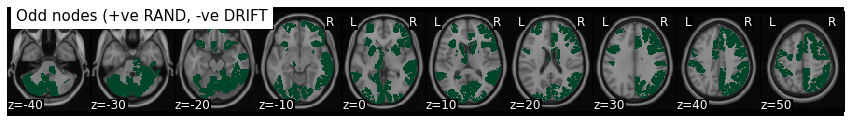

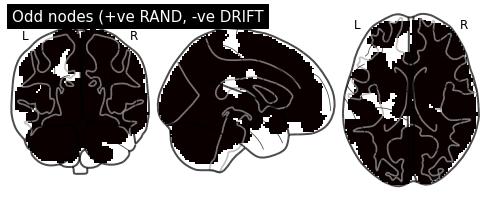

In [138]:
nodes = np.zeros((268,))
odd_nodes = (meanDiff_sl[:,0] < 0) & (meanDiff_sl[:,2] > 0)
nodes[odd_nodes] = 1
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = 'Odd nodes (+ve RAND, -ve DRIFT'
img.plot(title = txt,cmap='YlGn')
plot_glass_brain(img.to_nifti(), title=txt)
   



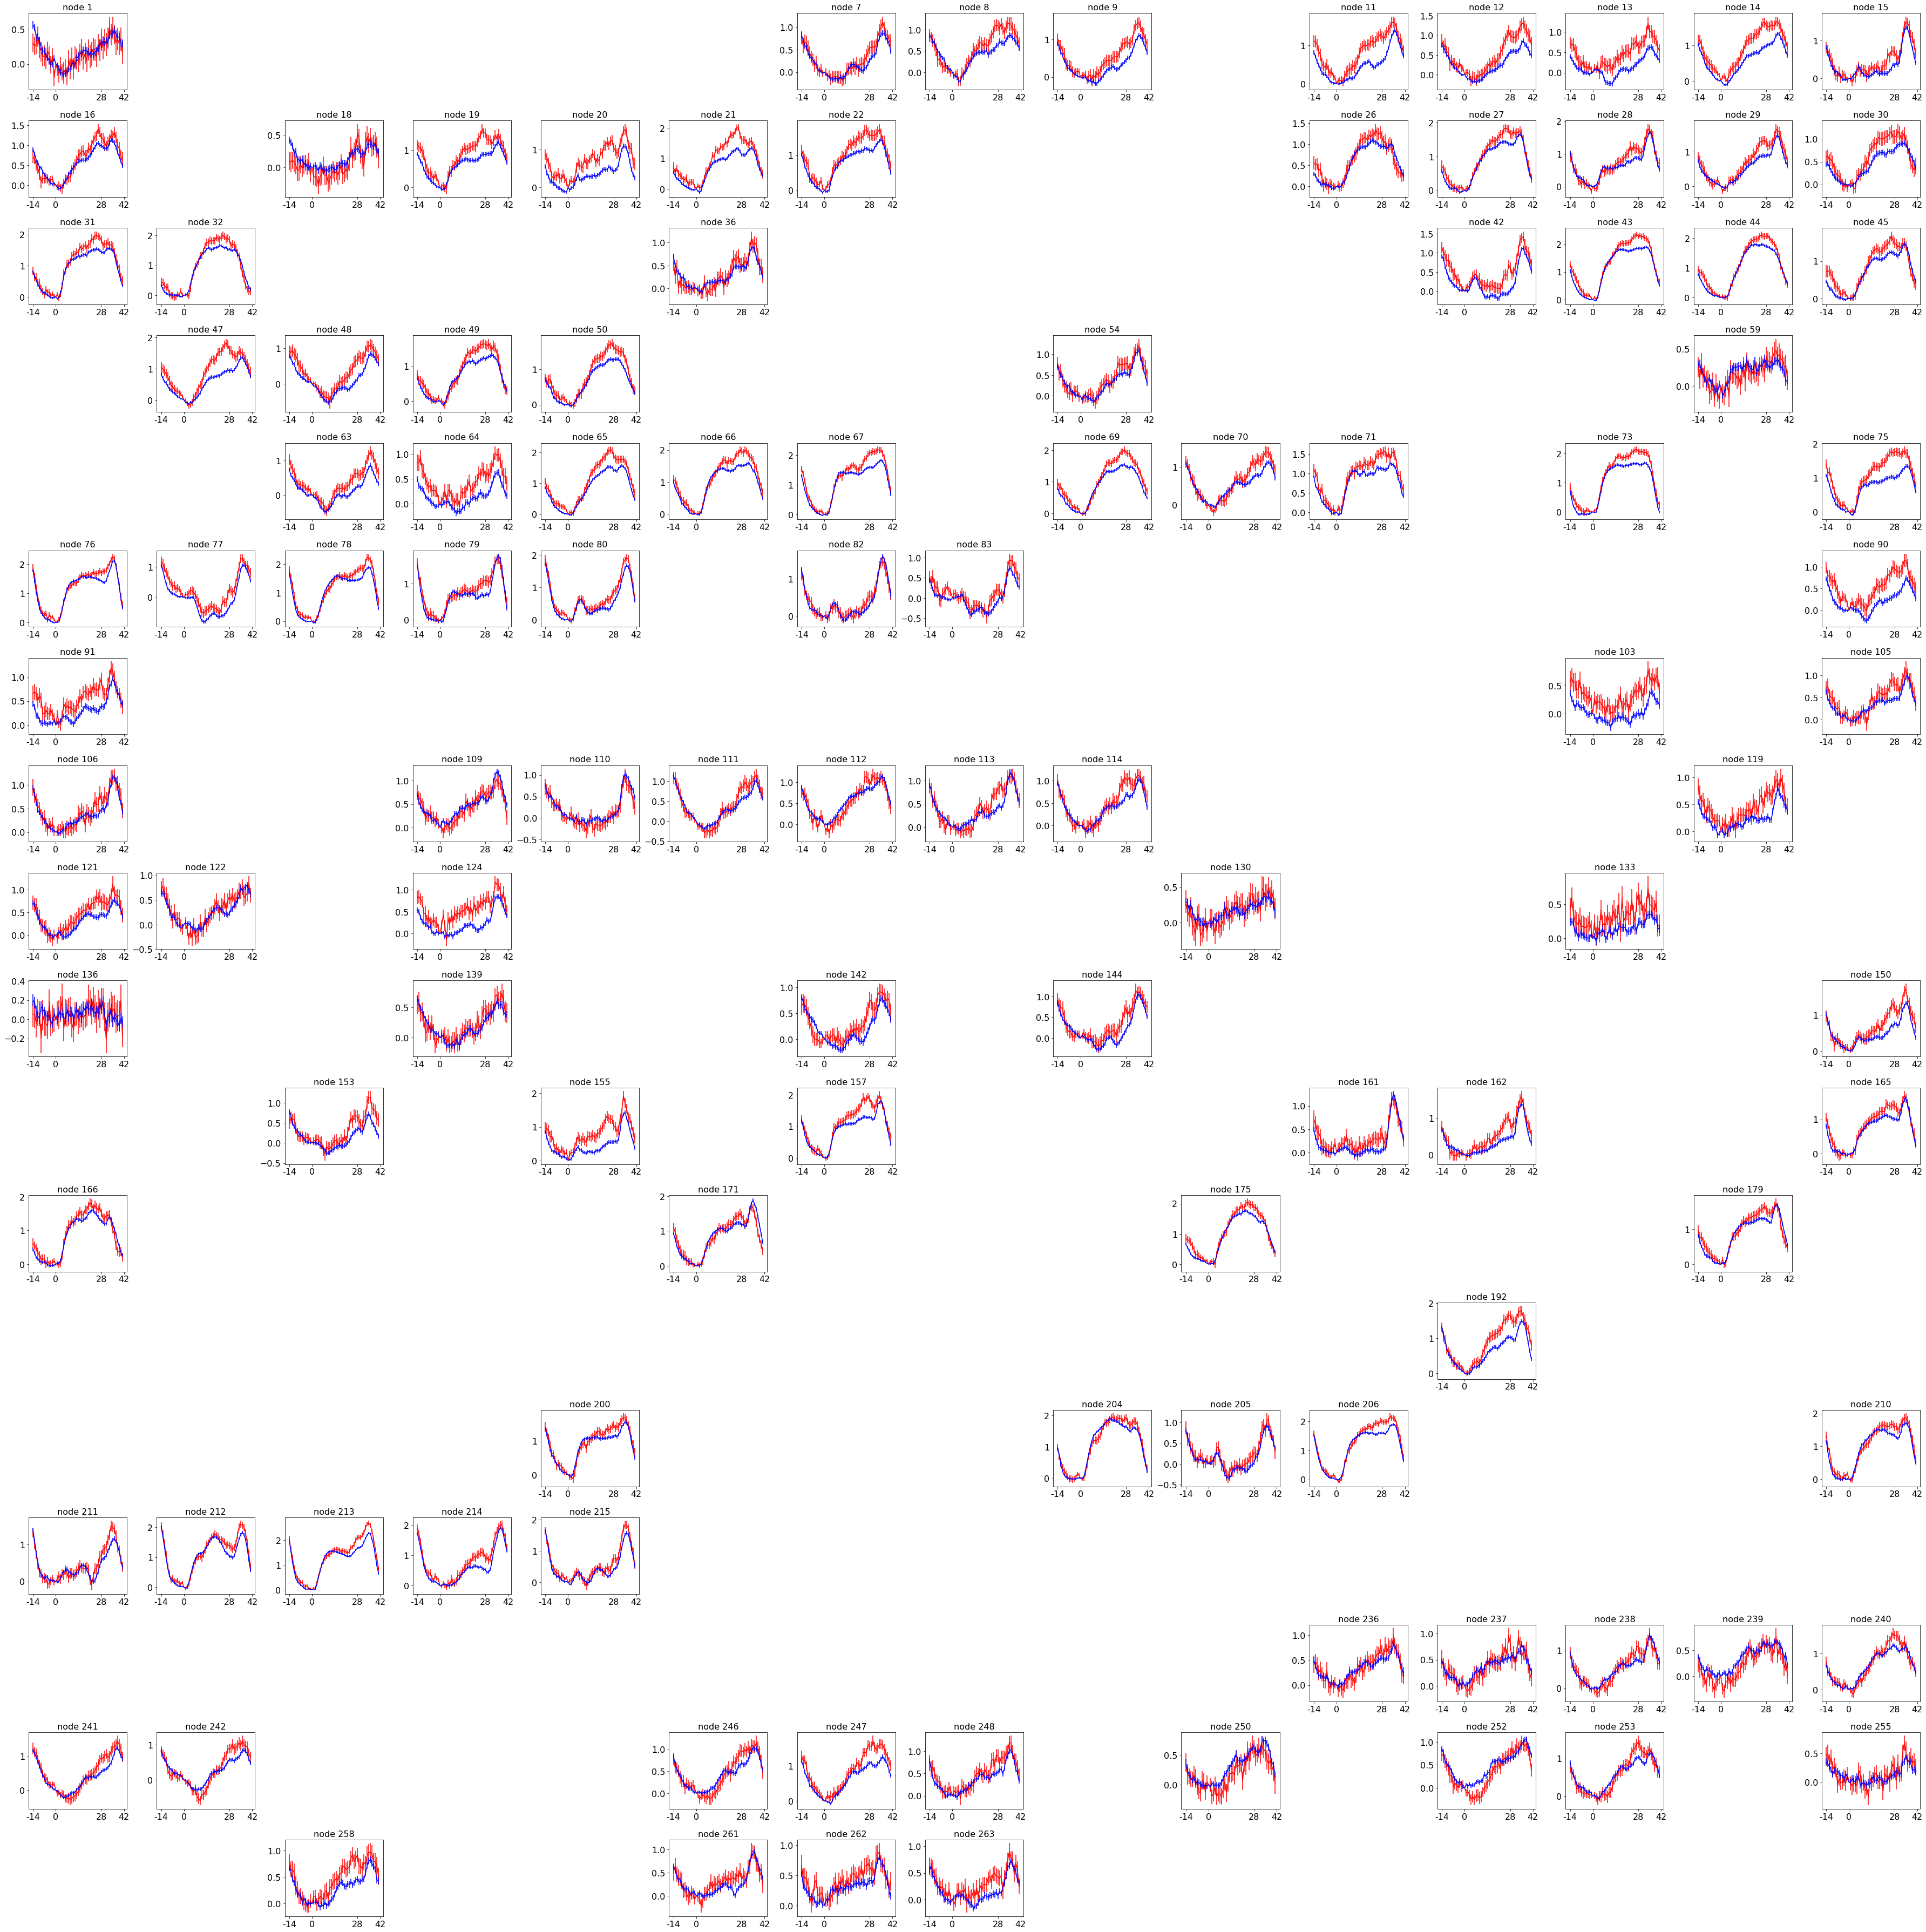

In [140]:
movie_ind = 4
plt.figure(2,figsize = (50,50))
for n in np.where(odd_nodes)[0]:
    plt.subplot(18,15,n+1)
    plt.title(f'node {n+1}')
    plt.errorbar(range(tcs_run_z.shape[2]), np.nanmean(tcs_run_z[responses[:,movie_ind]==1,n,:,movie_ind],axis=0), 
    stats.sem(tcs_run_z[responses[:,movie_ind]==1,n,:,movie_ind],axis=0),color = 'r')
    plt.errorbar(range(tcs_run_z.shape[2]), np.nanmean(tcs_run_z[responses[:,movie_ind]==0,n,:,movie_ind],axis=0), 
    stats.sem(tcs_run_z[responses[:,movie_ind]==0,n,:,movie_ind],axis=0),color = 'b')
    plt.xticks([0,vid_start_rel_tr[movie_ind],vid_start_rel_tr[movie_ind]+l_task,tcs_run_z.shape[2]],[str(i) for i in [-vid_start_rel_tr[movie_ind],0,l_task,tcs_run_z.shape[2]-vid_start_rel_tr[movie_ind]]])
plt.tight_layout()

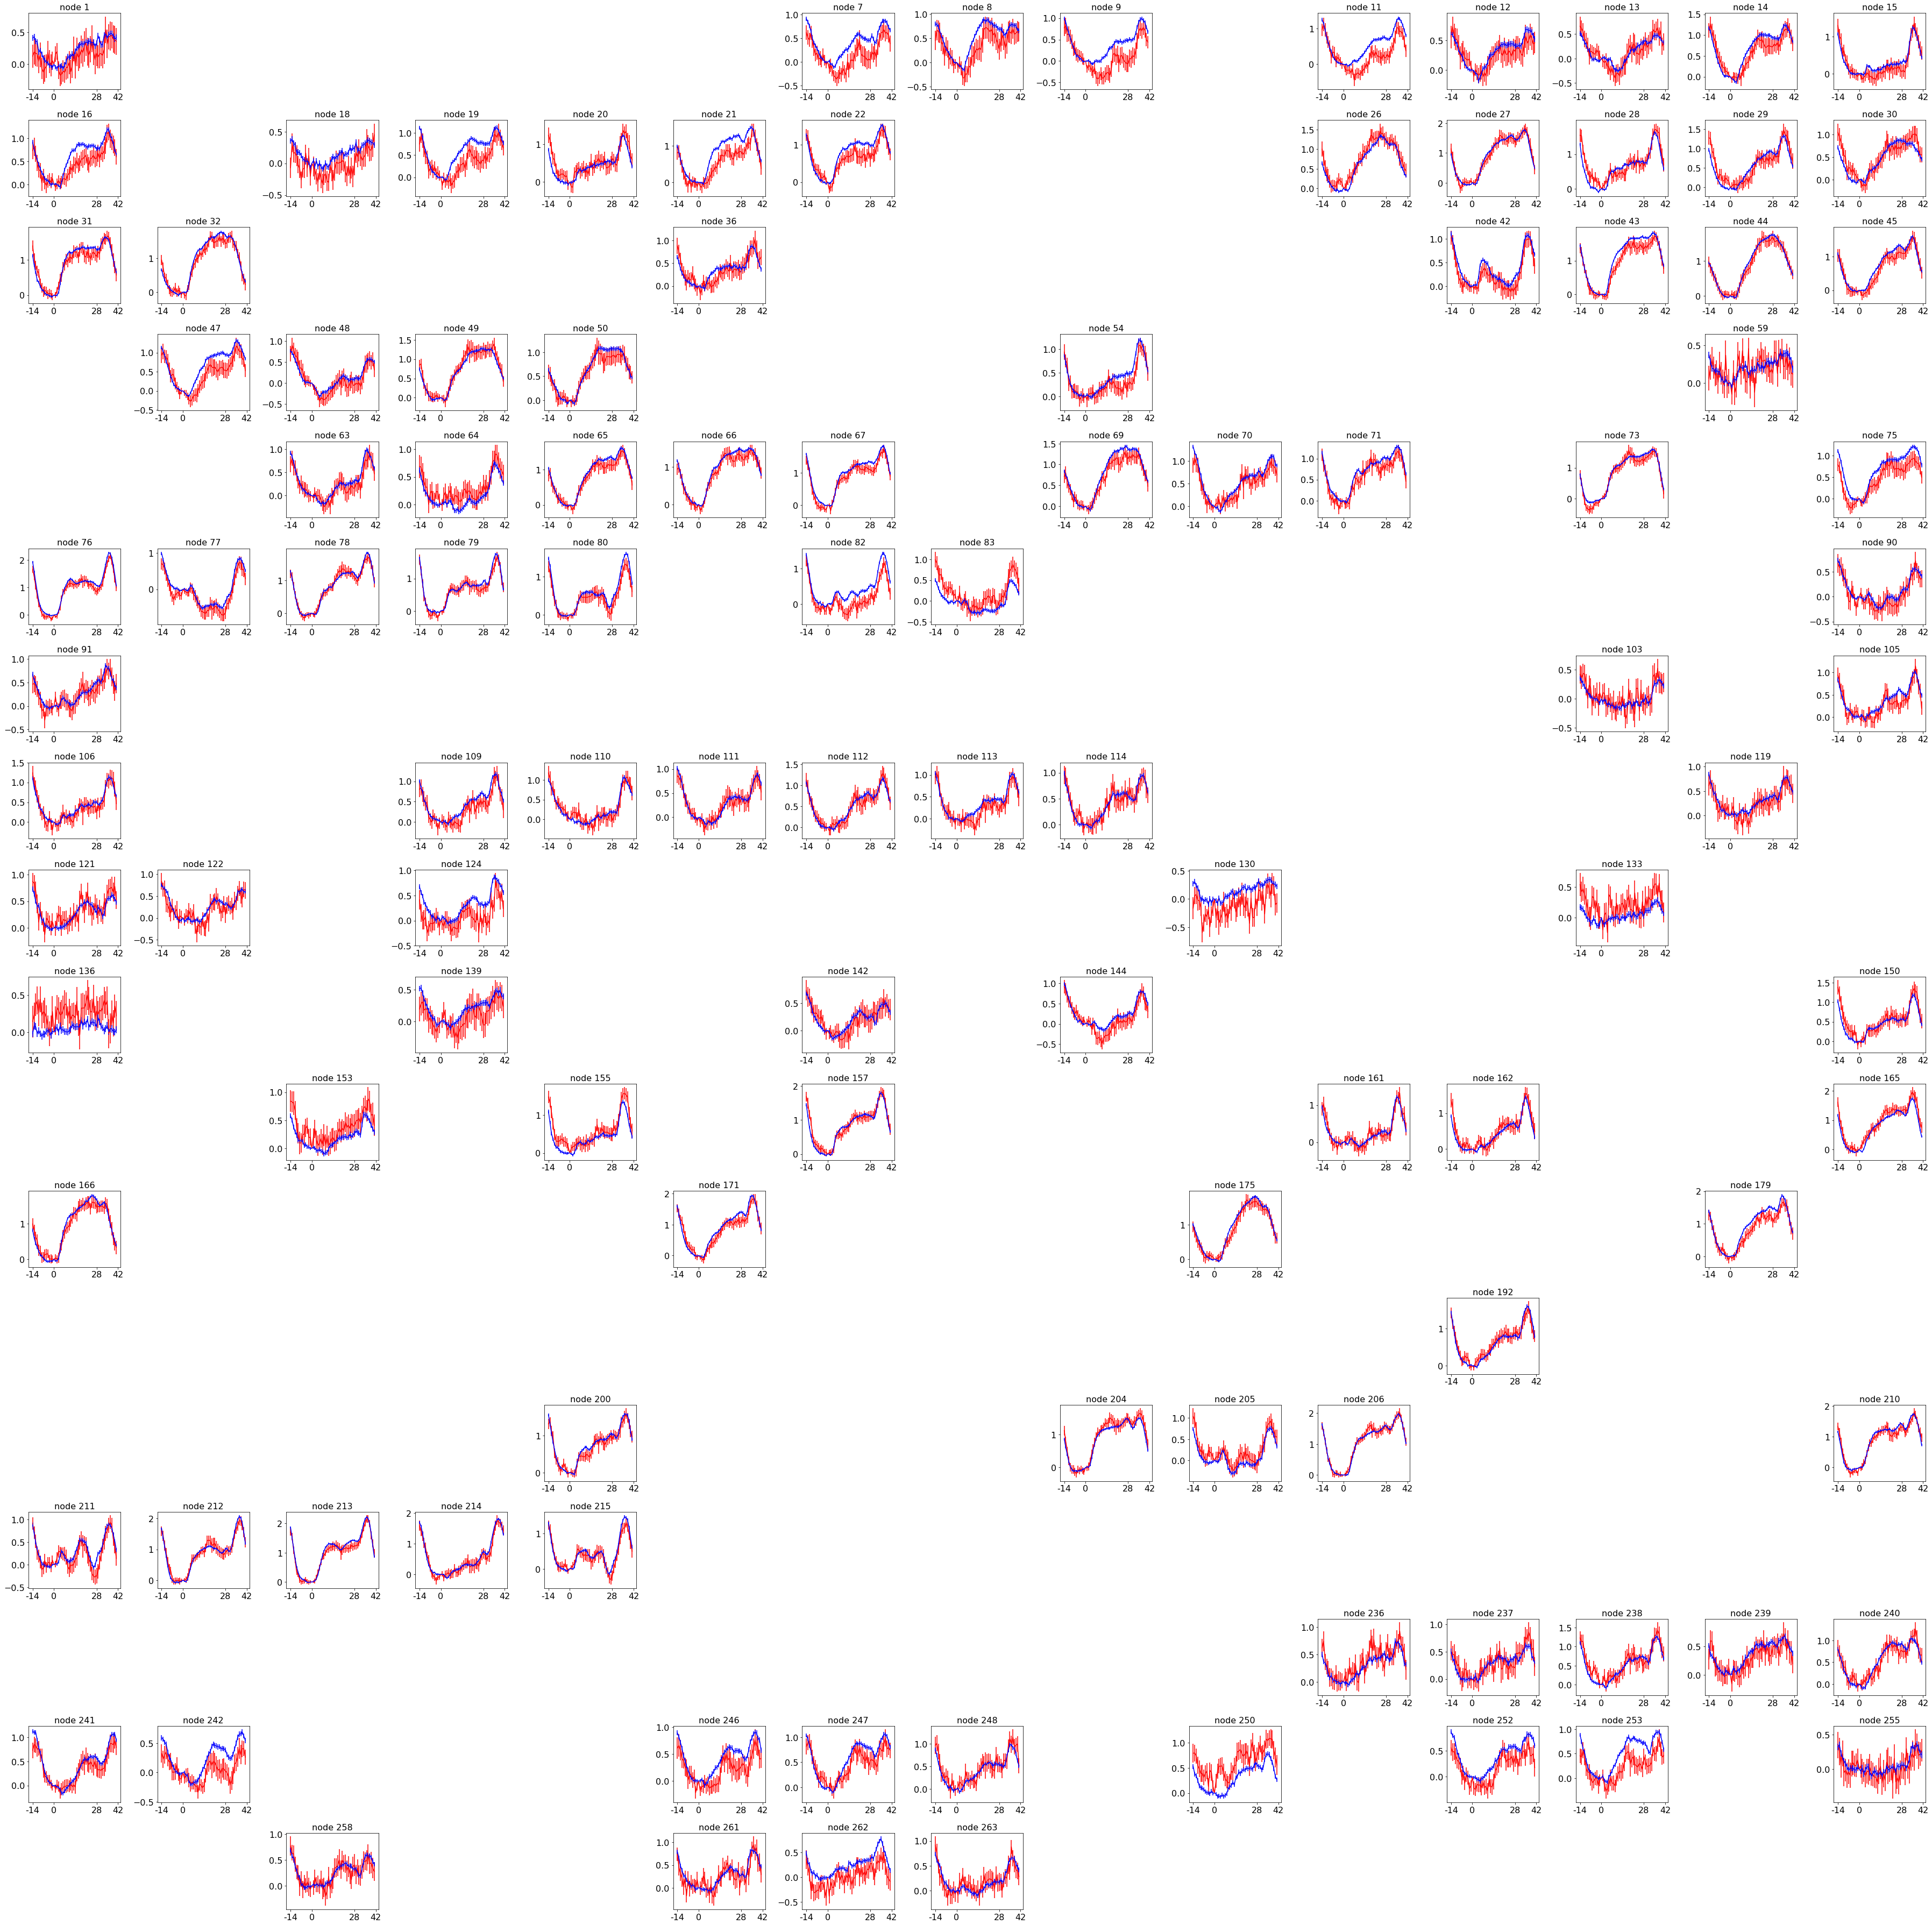

In [141]:
movie_ind = 2
plt.figure(2,figsize = (50,50))
for n in np.where(odd_nodes)[0]:
    plt.subplot(18,15,n+1)
    plt.title(f'node {n+1}')
    plt.errorbar(range(tcs_run_z.shape[2]), np.nanmean(tcs_run_z[responses[:,movie_ind]==1,n,:,movie_ind],axis=0), 
    stats.sem(tcs_run_z[responses[:,movie_ind]==1,n,:,movie_ind],axis=0),color = 'r')
    plt.errorbar(range(tcs_run_z.shape[2]), np.nanmean(tcs_run_z[responses[:,movie_ind]==0,n,:,movie_ind],axis=0), 
    stats.sem(tcs_run_z[responses[:,movie_ind]==0,n,:,movie_ind],axis=0),color = 'b')
    plt.xticks([0,vid_start_rel_tr[movie_ind],vid_start_rel_tr[movie_ind]+l_task,tcs_run_z.shape[2]],[str(i) for i in [-vid_start_rel_tr[movie_ind],0,l_task,tcs_run_z.shape[2]-vid_start_rel_tr[movie_ind]]])
plt.tight_layout()

In [143]:
shen268['47']

0    {'coords': [54.17796610169491, -45.2457627118644, 37.04237288135593], 'name': '48.64% Angular_Gyrus; 48.56% Supramarginal_Gyrus_posterior_division'}
Name: 47, dtype: object

 
-0.1921 x + 0.0002311
block: (-0.3262522366138867, 4.594916199750596e-08)
 
-0.1362 x + 0.09098
slope: (-0.21319904880977744, 0.000440755409386413)


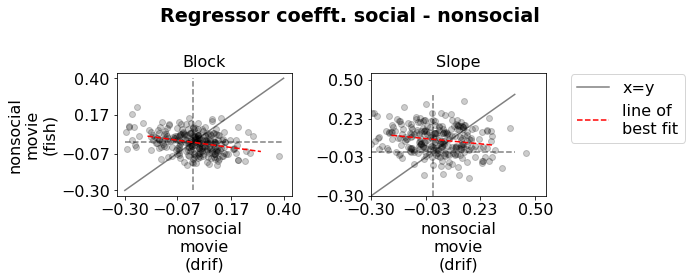

In [131]:
plt.figure(1,figsize=(10,4))
plt.suptitle('Regressor coefft. social - nonsocial',weight='bold')

plt.subplot(1,2,1)
plt.plot(np.linspace(-.3,.4,5),np.linspace(-.3,.4,5),color = 'grey')
plt.vlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.hlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.plot(meanDiff_bl[:,0],meanDiff_bl[:,1],ls = 'None',color = 'k',marker = 'o',alpha=.2)
plt.xlabel('nonsocial\nmovie\n(drif)')
plt.ylabel('nonsocial\nmovie\n(fish)')
plt.xticks([np.round(i,2) for i in np.linspace(-.3,.4,4)])
plt.yticks([np.round(i,2) for i in np.linspace(-.3,.4,4)])
stats.spearmanr(meanDiff_bl[:,0],meanDiff_bl[:,1])
m, b = np.polyfit(meanDiff_bl[:,0],meanDiff_bl[:,1], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(-.2,.3,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r')
print('block:',stats.pearsonr(meanDiff_bl[:,0],meanDiff_bl[:,1]))
plt.title('Block')


plt.subplot(1,2,2)
plt.plot(np.linspace(-.3,.4,5),np.linspace(-.3,.4,5),color = 'grey',label = 'x=y')
plt.vlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.hlines(0,-.3,.4,color = 'grey',ls = 'dashed')
plt.plot(meanDiff_sl[:,0],meanDiff_sl[:,1],ls = 'None',color = 'k',marker = 'o',alpha=.2)
plt.xlabel('nonsocial\nmovie\n(drif)')
plt.xticks([np.round(i,2) for i in np.linspace(-.3,.5,4)])
plt.yticks([np.round(i,2) for i in np.linspace(-.3,.5,4)])
stats.spearmanr(meanDiff_sl[:,0],meanDiff_sl[:,1])
m, b = np.polyfit(meanDiff_sl[:,0],meanDiff_sl[:,1], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(-.2,.3,10)
plt.plot(xplot, m*xplot + b,ls='dashed',color = 'r',label = 'line of \nbest fit')
print('slope:',stats.pearsonr(meanDiff_sl[:,0],meanDiff_sl[:,1]))
plt.title('Slope')
plt.xlim(-.3,.55)
plt.ylim(-.3,.55)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.tight_layout()

something weird about the fits above, try to remove outliers and fit again? Overall looks like the relationship is not too proportionate because the estimates for the FISH condition are noisy.

- looks like some of the nodes show a general similarity, but the FISH data is a lot noisier (TO DO: DOUBLE-CHECK THIS!!)

 
1.438 x + 0.07103
slope: (0.8629703884449562, 7.695764713583791e-81)


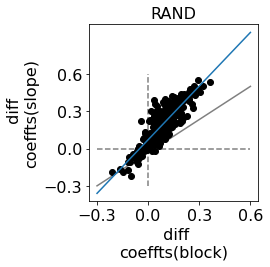

In [174]:
# correlate RAND block and slope
plt.figure(1,figsize=(4,4))
plt.plot(np.linspace(-.3,.6,5),np.linspace(-.3,.5,5),color = 'grey')
plt.vlines(0,-.3,.6,color = 'grey',ls = 'dashed')
plt.hlines(0,-.3,.6,color = 'grey',ls = 'dashed')
plt.plot(meanDiff_bl[:,1],meanDiff_sl[:,1],ls = 'None',color = 'k',marker = 'o')
plt.xlabel(' diff\ncoeffts(block)')
plt.ylabel(' diff\ncoeffts(slope)')
plt.xticks(np.linspace(-.3,.6,4))
plt.yticks(np.linspace(-.3,.6,4))
stats.spearmanr(meanDiff_bl[:,1],meanDiff_sl[:,1])
m, b = np.polyfit(meanDiff_bl[:,1],meanDiff_sl[:,1], 1)
print(np.poly1d([m,b]))
xplot = np.linspace(-.3,.6,10)
plt.plot(xplot, m*xplot + b)
print('slope:',stats.pearsonr(meanDiff_bl[:,1],meanDiff_sl[:,1]))
plt.title('RAND')

plt.tight_layout()

-0.08952719558320633


Ttest_relResult(statistic=-23.604784581742212, pvalue=2.6449351208648122e-67)

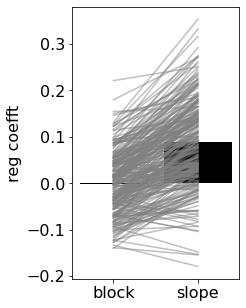

In [37]:
plt.figure(1,figsize=(3,5))
plt.bar(range(2),[np.nanmean(meanDiff_bl),np.nanmean(meanDiff_sl)], color = 'black')
plt.plot(range(2),np.array([meanDiff_bl,meanDiff_sl]), color = 'grey',alpha = .5)
plt.ylabel ('reg coefft')
plt.xticks([0,1],['block','slope'])
print(np.nanmean(meanDiff_bl)-np.nanmean(meanDiff_sl))
stats.ttest_rel(meanDiff_bl,meanDiff_sl)

- Random mech (RAND) had nodes that showed significant differences between reg coeffts for social and nonsocial responses 

## between movies - REDO THESE WITH LONGER FIXATION BASELINE PTS (IMPLEMENT IN PREPROC SCRIPT FIRST!!)

this analysis compares regression coefficients between two different movies - one highly social and one highly nonsocial (based on responses). an independent online study using these stimuli also showed that they had similar decision times - we use this info for some later timecourse analyses, so this current analysis is also to validate that.

234 ROIs sig. at p-value threshold .05

234 ROIs sig. at p-value threshold .05



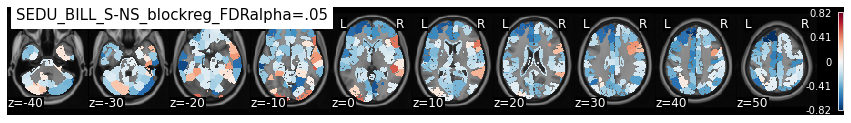

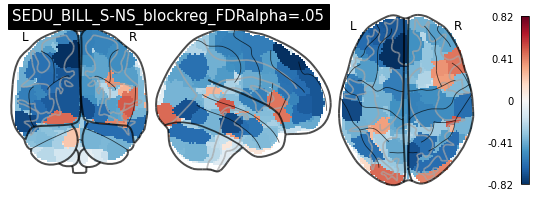

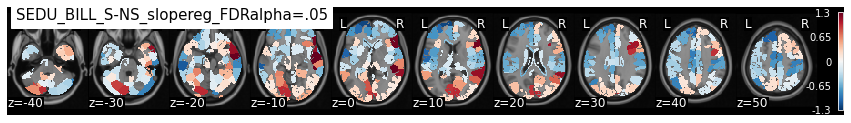

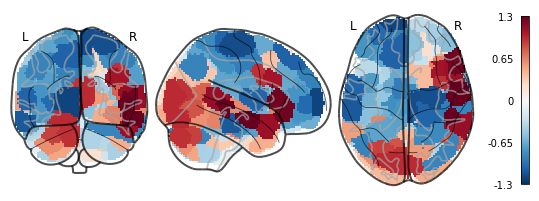

In [181]:
# block regressor
nodes = np.zeros((268,))
nodes[pval_block_bm<.05] = meanDiff_bl_bm[pval_block_bm<.05]
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = str.upper(vid_joined[movie_yes][:4]) + '_' + str.upper(vid_joined[movie_no][:4])  + '_S-NS_blockreg_FDRalpha=.05'
img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(), colorbar = True, title =  txt,plot_abs=False, cmap = 'RdBu_r')
img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_block_bm<.05)[0]]
print(f'{len(rois)} ROIs sig. at p-value threshold .05\n')


#slope regressor
nodes = np.zeros((268,))
nodes[pval_slope_bm<.05] = meanDiff_sl_bm[pval_slope_bm<.05]
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = str.upper(vid_joined[movie_yes][:4]) + '_' + str.upper(vid_joined[movie_no][:4])  + '_S-NS_slopereg_FDRalpha=.05'
img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs = False, cmap = 'RdBu_r')
img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_block_bm<.05)[0]]
print(f'{len(rois)} ROIs sig. at p-value threshold .05\n')


Let's see what's going on in the figure above - i.e., what the timecourses of the nodes with highest block regressors look like, and maybe underwstand why there's a lot of negative activation

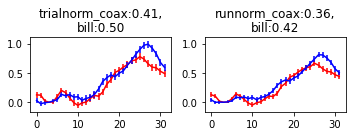

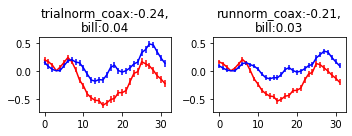

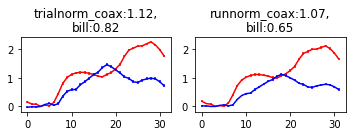

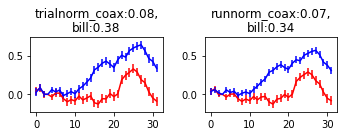

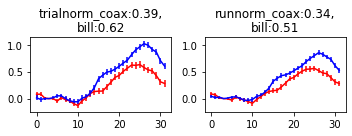

In [182]:
# plotting nodes with the highest mean differences between coax and reg
nodes = np.argsort(np.abs(meanDiff_bl_bm))[-5:]
subs = (responses[:,movie_yes]==1) & (responses[:,movie_no]==0)
for i,n in enumerate(nodes):
    plt.figure(i+1,figsize=(5,2))
    plt.subplot(121)
    plt.errorbar(range(32),np.nanmean(tcs_trial_z[subs,n,:,0],axis=0),stats.sem(tcs_trial_z[subs,n,:,0],axis=0,nan_policy = 'omit'),color ='r')
    plt.errorbar(range(32),np.nanmean(tcs_trial_z[subs,n,:,1],axis=0),stats.sem(tcs_trial_z[subs,n,:,1],axis=0,nan_policy = 'omit'),color ='b')
    plt.title(f'trialnorm_coax:{np.nanmean(coef_blockreg_trialnorm[subs,n,0]):.2f},\nbill:{np.nanmean(coef_blockreg_trialnorm[subs,n,1]):.2f}')
    ymin,ymax = plt.ylim()

    plt.subplot(122)
    plt.errorbar(range(32),np.nanmean(tcs_run_z[subs,n,:,0],axis=0),stats.sem(tcs_run_z[subs,n,:,0],axis=0,nan_policy = 'omit'),color ='r')
    plt.errorbar(range(32),np.nanmean(tcs_run_z[subs,n,:,1],axis=0),stats.sem(tcs_run_z[subs,n,:,1],axis=0,nan_policy = 'omit'),color ='b')
    plt.title(f'runnorm_coax:{np.nanmean(coef_blockreg_runnorm[subs,n,0]):.2f},\nbill:{np.nanmean(coef_blockreg_runnorm[subs,n,1]):.2f}')
    plt.ylim(ymin,ymax)

    plt.tight_layout()


nodes with negative responses do look negative.. maybe go back and check the normalization steps!

COAX social and BILL nonsocial for 1048 subs
186 ROIs sig. at p-value threshold .05

186 ROIs sig. at p-value threshold .05



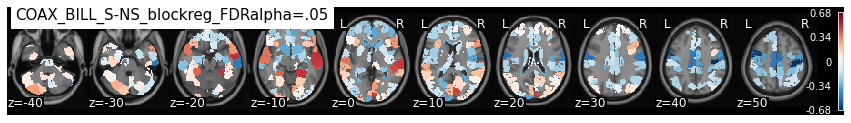

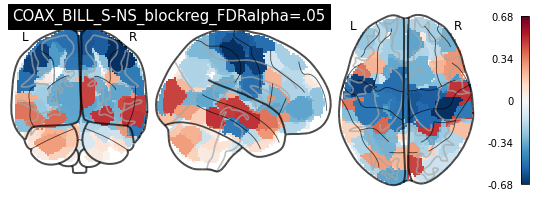

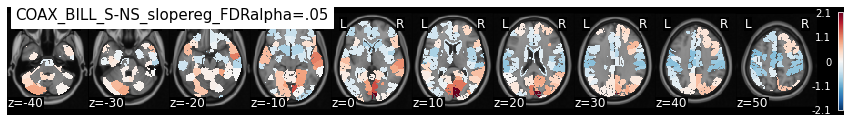

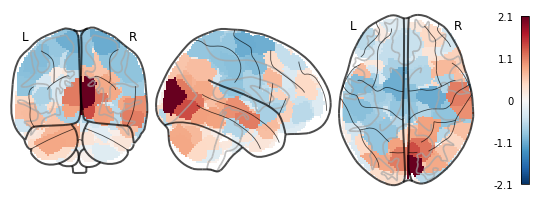

In [100]:
# COAX VS BILL - WITH RUNWISE NORMALIZED DATA. this would've preserved amplitude differences

nnodes = 268
nmovies = 10

subs = (responses[:,0]==1) & (responses[:,1]==0)
print(f'COAX social and BILL nonsocial for {len(subs)} subs')

# ttest between block regs
_,pval_block_bm_runwise = stats.ttest_rel(coef_blockreg_runnorm[subs,:,0], coef_blockreg_runnorm[subs,:,1],axis = 0)
meanDiff_bl_bm_runwise = np.nanmean(coef_blockreg_runnorm[subs,:,0] - coef_blockreg_runnorm[subs,:,1], axis = 0)

# ttest between slope regs yes vs. no
_,pval_slope_bm_runwise = stats.ttest_rel(coef_slopereg_runnorm[subs,:,0], coef_slopereg_runnorm[subs,:,1])
meanDiff_sl_bm_runwise = np.nanmean(coef_slopereg_runnorm[subs,:,0] - coef_slopereg_runnorm[subs,:,1],axis=0)

#fdr correction
_,pval_block_bm_runwise = fdr_correction(pval_block_bm_runwise,.05)
_,pval_slope_bm_runwise = fdr_correction(pval_slope_bm_runwise,.05)

# another possibility is to use run-normalized data to compare between movies - this way, we'd also see overall changes in activity (maybe this is better - not sure)



# block regressor
nodes = np.zeros((268,))
nodes[pval_block_bm_runwise<.05] = meanDiff_bl_bm[pval_block_bm_runwise<.05]
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = str.upper(vid_joined[0][:4]) + '_' + str.upper(vid_joined[1][:4])  + '_S-NS_blockreg_FDRalpha=.05'
img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(), colorbar = True, title =  txt,plot_abs=False, cmap = 'RdBu_r')
#img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_block_bm<.05)[0]]
print(f'{len(rois)} ROIs sig. at p-value threshold .05\n')


#slope regressor
nodes = np.zeros((268,))
nodes[pval_slope_bm_runwise<.05] = meanDiff_sl_bm[pval_slope_bm_runwise<.05]
img = roi_to_brain(pd.Series(nodes), mask_x)
txt = str.upper(vid_joined[0][:4]) + '_' + str.upper(vid_joined[1][:4])  + '_S-NS_slopereg_FDRalpha=.05'
img.plot(colorbar=True, title = txt, cmap = 'RdBu_r')
plot_glass_brain(img.to_nifti(), colorbar = True, plot_abs = False, cmap = 'RdBu_r')
#img.write(os.path.join(data_file_loc,'figures',txt + '.nii'))

rois = [eval(shen268[str(n+1)][0])['name'] for n in np.where(pval_block_bm<.05)[0]]
print(f'{len(rois)} ROIs sig. at p-value threshold .05\n')


the brainmaps looks very close to before - but what difference is there between the regression coeffts in both analyses?

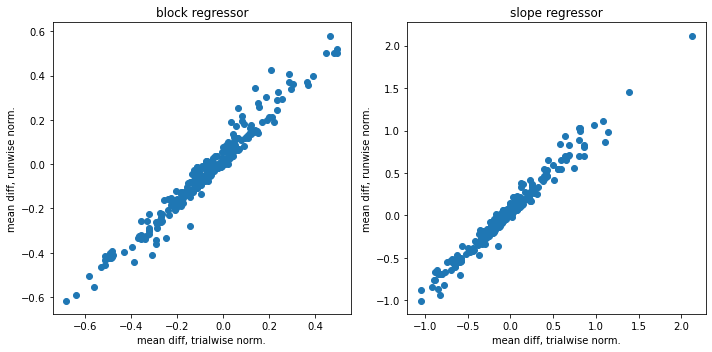

In [106]:
plt.figure(1,figsize=(10,5))
plt.subplot(121)
plt.title('block regressor')
plt.scatter(meanDiff_bl_bm,meanDiff_bl_bm_runwise)
plt.xlabel('mean diff, trialwise norm.')
plt.ylabel('mean diff, runwise norm.')
plt.subplot(122)
plt.title('slope regressor')
plt.scatter(meanDiff_sl_bm,meanDiff_sl_bm_runwise)
plt.xlabel('mean diff, trialwise norm.')
plt.ylabel('mean diff, runwise norm.')
plt.tight_layout()

These scatterplots confirm that (1) overall, the mean differences between regression coeffts (coax-bill) is the same across both types of normalizations (most nodes are along the diagonal),
(2) runwise normalization preserves the amplitude - higher mean difference for the runwise normalized data (Y-axis) for some nodes - positive is more positive and negative more negative for them.

But overall, looks like mean as well as the increase in neural activity across time is higher for nonsocial than social - which is the opposite of what we see for rand. 

## reviewers - stop here

# extra - ignore
## Comparing yes vs. no

In this section, I compare the beta values between yes and no responders for each movie using an unpaired t-test

In [56]:
# Computing t-scores between yes and no responses for each movie and node
nnodes = 268
nmovies = 10
tResp_movie_block = np.zeros((nnodes,nmovies))
pResp_movie_block = np.zeros((nnodes,nmovies))
mean_diff = np.empty((nnodes,nmovies))
for n in range(nnodes):
    for m in np.arange(nmovies):
        allresp = responses[:,m]
        current_node = est_movie_block[:,m,n]

        if current_node.shape != allresp.shape:
            print('error!')
        
        resp_yes = allresp==1
        resp_no  = allresp==0
        if n+m==0:
            print(len(current_node[resp_yes]))
            print(len(current_node[resp_no]))
        t,p = stats.ttest_ind(current_node[resp_yes],current_node[resp_no])
        
        tResp_movie_block[n,m] = t
        pResp_movie_block[n,m] = p  
        
        mean_diff[n,m] = np.nanmean(current_node[resp_yes])-np.nanmean(current_node[resp_no])
        

978
9


# UNFINISHED ANALYSES

/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Decoding accuracy')

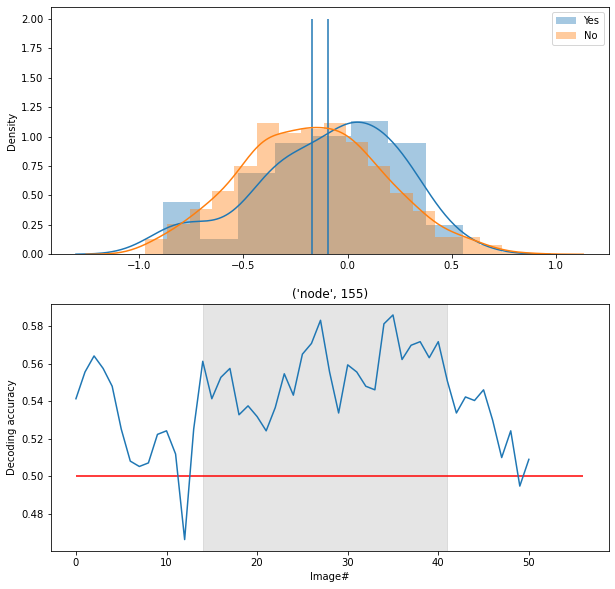

In [216]:
# TODO: EDIT THIS TO DO LEAVE-ONE-OUT: RIGHT NOW THE DATA USED TO CALCULATE MEAN IS USED TO ALSO PREDICT CATEGORY
import scipy as sp
DA = np.zeros((nt,))
for i in range(nt):
    tom_values = movie_tc[resp_yes,node,i]-movie_tc[resp_yes,node,0]
    tom_values = tom_values.squeeze()
    rnd_values = movie_tc[resp_no,node,i]-movie_tc[resp_no,node,0]
    rnd_values = rnd_values.squeeze()

    m_tom, s_tom = sp.stats.norm.fit(tom_values)
    m_rnd, s_rnd = sp.stats.norm.fit(rnd_values)

    movie_tc_bsln_corrected = movie_tc[:,node,i] - movie_tc[:,node,0]
    pred = [(abs(m_tom-x) < abs(m_rnd-x)) for x in movie_tc_bsln_corrected.squeeze()]
    DA[i] = (resp_yes==pred).sum()/len(resp_yes)
    #print((resp_yes==pred).sum()/len(resp_yes))

plt.figure(1,figsize =(10,10))
plt.subplot(211)
sns.distplot(tom_values, label='Yes')
sns.distplot(rnd_values, label='No')
plt.vlines([m_tom,m_rnd],0,2)
plt.gca().legend()

plt.subplot(212)
plt.plot(DA[5:])
plt.axvspan(np.where(reg)[0][0], np.where(reg)[0][-1], color = 'grey', alpha = .2, label = 'vidblock')  #vertical shading
plt.title(('node',node))
plt.hlines(.5,0,nt, color = 'r')
plt.xlabel('Image#')
plt.ylabel('Decoding accuracy')

# plt.gca().axvline(c, color='gray', linestyle='--')

/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Decoding accuracy')

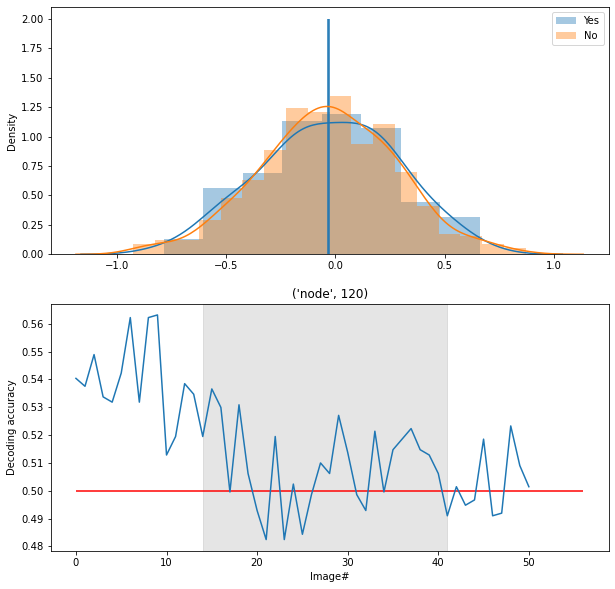

In [221]:
# TODO: EDIT THIS TO DO LEAVE-ONE-OUT: RIGHT NOW THE DATA USED TO CALCULATE MEAN IS USED TO ALSO PREDICT CATEGORY
node = min_rois_list.sort_values(by = ['T-scores'],ascending = True).iloc[0,:]['ROIs']
import scipy as sp
DA = np.zeros((nt,))
for i in range(nt):
    tom_values = movie_tc[resp_yes,node,i]-movie_tc[resp_yes,node,0]
    tom_values = tom_values.squeeze()
    rnd_values = movie_tc[resp_no,node,i]-movie_tc[resp_no,node,0]
    rnd_values = rnd_values.squeeze()

    m_tom, s_tom = sp.stats.norm.fit(tom_values)
    m_rnd, s_rnd = sp.stats.norm.fit(rnd_values)

    movie_tc_bsln_corrected = movie_tc[:,node,i] - movie_tc[:,node,0]
    pred = [(abs(m_tom-x) < abs(m_rnd-x)) for x in movie_tc_bsln_corrected.squeeze()]
    DA[i] = (resp_yes==pred).sum()/len(resp_yes)
    #print((resp_yes==pred).sum()/len(resp_yes))

plt.figure(1,figsize =(10,10))
plt.subplot(211)
sns.distplot(tom_values, label='Yes')
sns.distplot(rnd_values, label='No')
plt.vlines([m_tom,m_rnd],0,2)
plt.gca().legend()

plt.subplot(212)
plt.plot(DA[5:])
plt.hlines(.5,0,nt, color = 'r')
plt.axvspan(np.where(reg)[0][0], np.where(reg)[0][-1], color = 'grey', alpha = .2, label = 'vidblock')  #vertical shading
plt.title(('node',node))
plt.xlabel('Image#')
plt.ylabel('Decoding accuracy')
# plt.gca().axvline(c, color='gray', linestyle='--')

In [222]:
len(np.where(resp_unsure==True)[0])

186

In [223]:
movie_tc.shape

(1053, 268, 56)

/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/f0053cz/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibili

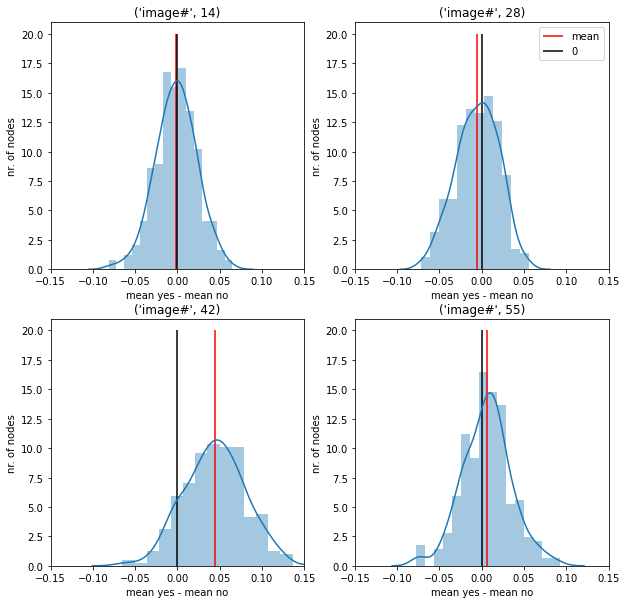

In [239]:
plt.figure(figsize =(10,10))
for i,t in enumerate([14,28,42,55]):
    plt.subplot(2,2,i+1)
    dt = np.mean(movie_tc[resp_yes,:,t],axis = 0)-np.mean(movie_tc[resp_no,:,t],axis=0)
    sns.distplot(dt)
    plt.vlines(np.mean(dt),0,20,'r', label = 'mean')
    plt.vlines(0,0,20,'k', label = '0')
    plt.xlabel('mean yes - mean no')
    plt.ylabel('nr. of nodes')
    plt.title(('image#',t))
    plt.xlim(-.15,.15)
    if i == 1:
        plt.legend()

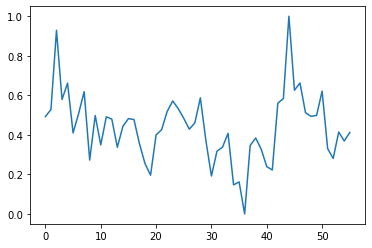

In [257]:
plt.plot(movie_tc[0,0,:])

In [275]:
def my_moving_window(x, window=3, FUN=np.mean):
    """
    Calculates a moving estimate for a signal

    Args:
      x (numpy.ndarray): a vector array of size N
      window (int): size of the window, must be a positive integer
      FUN (function): the function to apply to the samples in the window

    Returns:
      (numpy.ndarray): a vector array of size N, containing the moving
      average of x, calculated with a window of size window

    There are smarter and faster solutions (e.g. using convolution) but this
    function shows what the output really means. This function skips NaNs, and
    should not be susceptible to edge effects: it will simply use
    all the  available samples, which means that close to the edges of the
    signal or close to NaNs, the output will just be based on fewer samples. By
    default, this function will apply a mean to the samples in the window, but
    this can be changed to be a max/min/median or other function that returns a
    single numeric value based on a sequence of values.
    """

    # if data is a matrix, apply filter to each row:
    if len(x.shape) == 2:
        output = np.zeros(x.shape)
        for rown in range(x.shape[0]):
            output[rown, :] = my_moving_window(x[rown, :],
                                             window=window,
                                             FUN=FUN)
        return output

    # make output array of the same size as x:
    output = np.zeros(x.size)

    # loop through the signal in x
    for samp_i in range(x.size):

        values = []

        # loop through the window:
        for wind_i in range(int(1 - window), 1):

            if ((samp_i + wind_i) < 0) or (samp_i + wind_i) > (x.size - 1):
                # out of range
                continue

            # sample is in range and not nan, use it:
            if not(np.isnan(x[samp_i + wind_i])):
                values += [x[samp_i + wind_i]]

        # calculate the mean in the window for this point in the output:
        output[samp_i] = FUN(values)

    return output

In [456]:
Y

array([[0.10751863, 0.11746135, 0.26501879, ..., 0.32124397, 0.19901462,
        0.17814644],
       [0.36747594, 0.41783054, 0.43670483, ..., 0.26009948, 0.37310864,
        0.47830314],
       [0.30790992, 0.2966901 , 0.2979963 , ..., 0.23471367, 0.2138238 ,
        0.31184758],
       ...,
       [0.51056737, 0.35608242, 0.23778827, ..., 0.49683874, 0.31448227,
        0.35214761],
       [0.59991329, 0.41567534, 0.31669908, ..., 0.62322599, 0.5068817 ,
        0.31741748],
       [0.65072194, 0.48465843, 0.8073899 , ..., 0.22495353, 0.21936262,
        0.3299803 ]])

<ErrorbarContainer object of 3 artists>

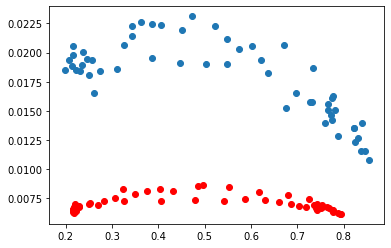

In [455]:
Y = movie_tc[resp_yes,73,:]
plt.errorbar(np.mean(Y,axis=0), stats.sem(Y, axis = 0),marker = 'o', ls = 'none')

Y = movie_tc[resp_no,73,:]
plt.errorbar(np.mean(Y,axis=0), stats.sem(Y, axis = 0),marker = 'o', color = 'r', ls = 'none')

In [411]:
len(np.where(resp_no==True)[0])

588

In [760]:
max_timept = np.zeros((268,2))
nsub_yes = len(np.where(resp_yes==True)[0])
nsub_no = len(np.where(resp_no==True)[0])
for node in range(268):
    maxt_yes = np.zeros((nsub_yes,))
    maxt_no  = np.zeros((nsub_no,))
    #print('node',node)
    yall_yes = movie_tc[resp_yes,node,:]
    for subj in range(nsub_yes):
        #print('subj',subj)
        Y = yall_yes[subj,:]
        Y = my_moving_window(Y)
        Y = Y[15:45]
        #print( np.where(Y==np.max(Y))[0])
        #print(np.where(movie_tc[subj,node,:]==np.max(movie_tc[subj,node,:]))[0][0])
        maxt_yes[subj] = np.where(Y==np.max(Y))[0]
    
    yall_no = movie_tc[resp_no,node,:]
    for subj in range(nsub_no):   
        Y = yall_no[subj,:]
        Y = my_moving_window(Y)
        Y = Y[15:45]
        #print(np.where(movie_tc[subj,node,:]==np.max(movie_tc[subj,node,:]))[0][0])
        maxt_no[subj] = np.where(Y==np.max(Y))[0]
    #max_timept[node] = np.mean(np.array(maxt_yes)) - np.mean(np.array(maxt_no))
    max_timept[node,0] = np.mean(np.array(maxt_yes))
    max_timept[node,1] = np.mean(np.array(maxt_no))

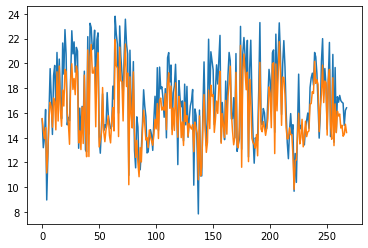

In [744]:
plt.plot(max_timept)


In [395]:
#print(early_rois)
ind = -1
#roi_lbl = []
node_array = np.zeros(len(early_rois))
#print(node_array)
roi_lbl = ["" for x in range(len(early_rois))]
for node_nr in early_rois:
    ind += 1
    roi_lbl[ind] = shen268[str(node_nr)][0]
    node_array[ind] = np.round(node_nr)

#print(type(node_array))
#print(roi_lbl)
#print(max_timept[node_array.astype(int)])
early_rois_list = pd.DataFrame({'imagenr': max_timept[node_array.astype(int)],'node': node_array, 'ROIs': roi_lbl})

In [396]:
#print(early_rois)
ind = -1
#roi_lbl = []
node_array = np.zeros(len(late_rois))
#print(node_array)
roi_lbl = ["" for x in range(len(late_rois))]
for node_nr in late_rois:
    ind += 1
    roi_lbl[ind] = shen268[str(node_nr)][0]
    node_array[ind] = np.round(node_nr)

#print(type(node_array))
#print(roi_lbl)
#print(max_timept[node_array.astype(int)])
late_rois_list = pd.DataFrame({'imagenr': max_timept[node_array.astype(int)], 'node': node_array, 'ROIs': roi_lbl})

In [763]:
max_timept_cert = np.zeros((268,2))
nsub_sure = len(np.where(resp_sure==True)[0])
nsub_unsure = len(np.where(resp_unsure==True)[0])
for node in range(268):
    maxt_sure = np.zeros((nsub_sure,))
    maxt_unsure = np.zeros((nsub_unsure,))
    #print('node',node)
    yall_sure = movie_tc[resp_sure,node,:]
    for subj in range(nsub_sure):
        #print('subj',subj)
        Y = yall_sure[subj,:]
        Y = my_moving_window(Y)
        Y = Y[15:45]
        #print( np.where(Y==np.max(Y))[0])
        #print(np.where(movie_tc[subj,node,:]==np.max(movie_tc[subj,node,:]))[0][0])
        #print(np.where(Y==np.max(Y))[0])
        maxt_sure[subj] = np.where(Y==np.max(Y))[0][0]
    
    yall_unsure = movie_tc[resp_unsure,node,:]
    for subj in range(nsub_unsure):  
        #print(subj)
        Y = yall_unsure[subj,:]
        #Y = my_moving_window(Y)
        Y = Y[15:45]
        #print(np.where(movie_tc[subj,node,:]==np.max(movie_tc[subj,node,:]))[0][0])
        maxt_unsure[subj] = np.where(Y==np.max(Y))[0][0]
    #max_timept[node] = np.mean(np.array(maxt_yes)) - np.mean(np.array(maxt_no))
    max_timept_cert[node,0] = np.mean(np.array(maxt_sure))
    max_timept_cert[node,1] = np.mean(np.array(maxt_unsure))

([<matplotlib.axis.XTick at 0x7ffdee616640>,
 [Text(0, 0, '-14'),
  Text(5, 0, '-9'),
  Text(10, 0, '-4'),
  Text(15, 0, '1'),
  Text(20, 0, '6'),
  Text(25, 0, '11'),
  Text(30, 0, '16'),
  Text(35, 0, '21'),
  Text(40, 0, '26'),
  Text(45, 0, '31'),
  Text(50, 0, '36'),
  Text(55, 0, '41')])

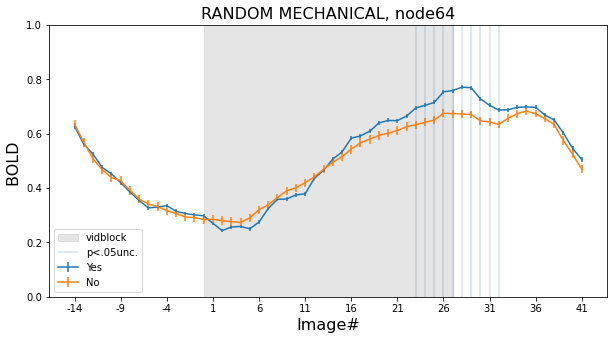

In [784]:
pthresh = np.where(pval<.05)[0]
plt.figure(figsize = (10,5))
#plt.plot(reg_conv[4] , label = 'regressor')
#plt.errorbar(x = range(72),y = np.mean(movie_tc[:,node,:], axis = 0), 
#             yerr = stats.sem(movie_tc[:,node,:],axis = 0), label ='all')
plt.errorbar(x = range(nt),y = np.mean(movie_tc[resp_yes,node,:], axis = 0), 
             yerr = stats.sem(movie_tc[resp_sure,node,:],axis = 0), label = 'Yes')
plt.errorbar(x = range(nt),y = np.mean(movie_tc[resp_no,node,:], axis = 0), 
             yerr = stats.sem(movie_tc[resp_unsure,node,:],axis = 0), label = 'No')
plt.axvspan(np.where(reg)[0][0], np.where(reg)[0][-1], color = 'grey', alpha = .2, label = 'vidblock')  #vertical shading
plt.vlines(pthresh, -.5,1.4, alpha = .2, label = 'p<.05unc.')
plt.legend(loc = 'lower left')
plt.ylim(0,1)
plt.title((str.upper(vid_joined[movie_ind]) +', node' + str(node)), fontsize = 16)
plt.ylabel('BOLD ', fontsize = 16)
plt.xlabel('Image#', fontsize = 16)
tks = np.arange(0,nt,5)-np.where(reg)[0][0]
tks = [str(i) for i in tks]
plt.xticks(np.arange(0,nt,5),tks)



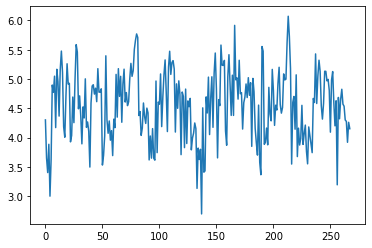

In [402]:
plt.plot(max_timept_bin)
#plt.axhspan(np.where(reg)[0][0], np.where(reg)[0][-1], color = 'grey', alpha = .2, label = 'vidblock')  #vertical shading

## Extra

In [ ]:

'''

# run wise norm data, coax vs. bill comparison
from mne.stats import fdr_correction

nnodes = 268
nmovies = 10
pval_block_bm_run = np.empty((nnodes,))
meanDiff_bl_bm_run = np.empty_like(pval_block_bm_run)
pval_slope_bm_run = np.empty_like(pval_block_bm_run)
meanDiff_sl_bm_run = np.empty_like(pval_block_bm_run)
pval_block_bm_run[:] = np.nan
meanDiff_bl_bm_run[:] = np.nan
pval_slope_bm_run[:] = np.nan
meanDiff_sl_bm_run[:] = np.nan


soc_inds = responses[:,0]==1
nonsoc_inds = responses[:,1]==0
print(f'yes={len(np.where(soc_inds)[0])},no={len(np.where(nonsoc_inds)[0])}')
for n in range(nnodes):
    # ttest between block regs
    _,pval_block_bm_run[n] = stats.ttest_ind(est_movie_block[soc_inds,n,0],
                                    est_movie_block[nonsoc_inds,n,1],equal_var=False)
    meanDiff_bl_bm_run[n] = np.nanmean(est_movie_block[soc_inds,n,0])- \
                    np.nanmean(est_movie_block[nonsoc_inds,n,1])

    # ttest between slope regs yes vs. no
    _,pval_slope_bm_run[n] = stats.ttest_ind(est_movie_slope[soc_inds,n,0],
                                est_movie_slope[nonsoc_inds,n,1],equal_var=False)
    meanDiff_sl_bm_run[n] = np.nanmean(est_movie_slope[soc_inds,n,0])-\
                    np.nanmean(est_movie_slope[nonsoc_inds,n,1])

#fdr correction
_,pval_block_bm_run = fdr_correction(pval_block_bm_run,.05)
_,pval_slope_bm_run = fdr_correction(pval_slope_bm_run,.05)'''

- Further, I plotted the BOLD timecourses for the nodes with the highest difference between 'yes' and 'no' responders' beta values and performed paired t-test at each timepoint to find the point of divergence
- Parallelly, I also split subjects (and consequently beta values from step 2) into 'sure' (yes/no) and 'unsure' responses, and computed (1) the T-scores of sure-unsure for each node (and plotted it), and (2) for the brain regions that showed the meaximal sure-unsure difference, the difference between mean activity at each timepoint (same two analyses as for yes vs no)

- I also performed a similar analysis for the GLM: BOLD = f(stimTimecourse, responseScreen), stimTimecourse &isin; [0,28(i.e.,20s)] and responseScreen &isin; {0,1}. This is stored in the notebook: fMRI_analysis-trialwiseGLM_slopes_timecourses.ipynb in the same folder.

In [ ]:
# run-wise normalized data

coef_blockreg_runnorm = np.zeros((tcs_run_z.shape[0], tcs_run_z.shape[1], tcs_run_z.shape[3])) # variable to store the regression coeffts or beta estimates. 
# dims nsubs,nnodes,nmovies

start = time.time()

X = reg_block.reshape((-1, 1))

if __name__ == '__main__':
    pool = Pool(processes=cpu_count()) # helps to parallelize processing

for s in range(tcs_run_z.shape[0]): # number of subjects
    # print(s)
    if s%100 == 0:
        now = time.time()
        print(f'sub:{s}, time elapsed:{(now - start)/60:.2f}mins')

    for movie_ind in range(tcs_run_z.shape[3]):
        #coef_blockreg_runnorm[s,:,movie_ind] = np.array([LinearRegression().fit(X, tcs_run_z[s,n,:,movie_ind]).coef_[0] for n in range(tcs_run_z.shape[1])])
        
        tcs = [y for y in tcs_run_z[s,:,:,movie_ind]] # list of length nnodes (268), each element of the list is a [32,] timcourse array
        coef_blockreg_runnorm[s,:,movie_ind] = pool.map(lm_estimate,tcs) # eatimate returned as a list of size 268

        '''for n in range(tcs_run_z.shape[1]): # number of nodes
        #    coef_blockreg_runnorm[s,n,movie_ind] = glm_estimate(tcs_run_z[s,n,:,movie_ind])
        
            Y = tcs_run_z[s,n,:,movie_ind]
            model = LinearRegression().fit(X, Y) # normalised data
            coef_blockreg_runnorm[s,n,movie_ind] = model.coef_[0] #normalised data'''
            
now = time.time()
print(f'Done.total time:{(now-start)/60:.2f}mins')

if s == tcs_run_z.shape[0]:
    np.save(os.path.join(data_file_loc,'coef_blockreg_runnorm.npy'),coef_blockreg_runnorm)


In [ ]:
#names of videos per run (always presented the same across subjects)
vid_names = {}
vid_names["run1"] = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical"]#RL
vid_names["run2"] = ["Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]#LR
vid_joined = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", "Random mechanical", "Scaring", "SEDUCING-B", "STAR-A", "SURPRISING-B", "TENNIS-A"]
vid_cat = {}
vid_cat["run1"] = [1,0,0,1,0] # 1:mental,0: random
vid_cat["run2"] = [1,1,0,1,0]

#read in the shen-parcellated timecourses for all subjects and all nodes (subj*timecourseperrun*node)
f_RL = h5py.File("shen268_timecourses_RL.hdf5", "r") 
f_LR = h5py.File("shen268_timecourses_LR.hdf5", "r")

#playing around with this datatype
type(f_RL)
print('f_RL.keys()=',f_RL.keys(), '\n') # h5py.File() acts like a dictionary

# Exploring the datatype
d = f_RL['shen268_timecourses'] 
print('type(d)=', type(d))# d is of type Dataset. Like NumPy arrays, datasets have both a shape and a data type.
print('d.shape=',d.shape) # subjects, scan volumes, nodes
print('d.dtype=',d.dtype)
print('d=',d, "\n")

d_RL = np.array(f_RL['shen268_timecourses']) # extracting timecourses and converting them to arrays
print('type(d_RL):',type(d_RL))
print('d_RL.shape',d_RL.shape)
#plt.matshow(d_RL[0,1:50,1:100]) # time vs. nodes
sns.heatmap(d_RL[0,1:50,1:100]) # plot a few timepts and nodes to get an idea
plt.xlabel("nodes")
plt.ylabel("timecourse")
print('d_RL.shape',d_RL.shape)

#extract fMRI data and subject names
dat = {}
dat["run1"] = np.array(f_RL['shen268_timecourses'])
dat["run2"] = np.array(f_LR['shen268_timecourses'])

subj_list = {}
subj_list["run1"] = [x.decode('utf8') for x in list(f_RL['subjlist'])] #RL --> order of subjects for run 1
subj_list["run2"] = [x.decode('utf8') for x in list(f_LR['subjlist'])] #LR

In [ ]:
# info needed to make a block regressor
vid_onsets_in_sec = [8, 46, 84, 122, 160]
tr = 0.72
duration_secs = 20
l_task = int(np.round(duration_secs/tr))  # duration measured in nr of images = 28 for 20s
print('Duration of task block:', l_task)
print('Nr of fixation images:', np.round(15/tr))
l_fix = int(l_task/2)
print('setting baseline images at:',l_fix) # since there's fixation pre and post task block


#exploring the timecourse
vid_onsets_imagenr = np.zeros_like(vid_onsets_in_sec)
for i in range(5):
    vid_onsets_imagenr[i] = np.floor((vid_onsets_in_sec[i]/tr)-1) # seconds to image nr (-1 since indices start from 0)
print(vid_onsets_imagenr)
print(np.diff(vid_onsets_imagenr)) # sanity check: are the distances between onset images the same?

In [ ]:
#create moviewise block regressors

reg_conv = []
nmovies = 10
yrows = [] # 10x1 list of rows
plt.figure(figsize = (10,3))
for vid_no in range(nmovies):
    run = "run1" if vid_no < 5 else "run1"
    vrun = vid_no%5
    vid = vid_names[run][vrun]
    #print(vid)
    vidonset_imnr = np.floor((vid_onsets_in_sec[vrun]/tr)-1)
    if vrun == 0:
        start_frame = 0
    else:
        start_frame = int(vidonset_imnr) - l_fix # 14 frames of fix before task block
    #print('start_frame',start_frame)
    #if vrun == 4:
    #    end_frame = 274
    #else:
    end_frame = int(vidonset_imnr) + l_task + l_fix # 14 frames of fix after task block
    yrows_stim = np.arange(start_frame,end_frame)
    yrows.append(yrows_stim)
    vid_start = int(vidonset_imnr) # get the relevant frames by converting sec to tr
    vid_start = vid_start - start_frame
    #print('vid_start',vid_start)
    vid_end = vid_start + l_task
    #print('vid_end',vid_end)
    reg = np.zeros((end_frame-start_frame))
    reg[vid_start:vid_end] = 1
    #print(reg)
    #plt.subplot(5,2,vid_no+1)
    if vid_no == 0:
        plt.figure(figsize = (3,3))
        plt.plot(reg, label = 'block reg.', color = 'grey')
    reg1 = np.convolve(reg, hrf)
    #print('before:',len(reg), ', after',len(reg1))
    #reg1 = reg1[5:5+len(reg)]
    reg1 = reg1[:len(reg)]
    if vid_no == 0:
        plt.plot(reg1, label = 'reg. conv.')
        #plt.legend(loc = 'lower left', fontsize = 16)
        #plt.xlabel('Image #', fontsize = 16)
        #plt.xticks(fontsize = 16)
        plt.xticks([])
        plt.yticks([0,1],['Fix.','Movie'], fontsize = 16)
    reg_conv.append(reg1)


In [ ]:
#extract behavioral data
beh_data = pd.read_csv("/Users/f0053cz/Documents/HCP_SOCIALforRekha-001/HCP_SOCIALforRekha/hcp_social_behav_for_ddm_stim-coding.csv")
rtmin = 0.1 # threshold for impossibly short RTs

print('nrows before removing short RTs=', beh_data.shape)
print("total subjects before=",len(np.unique(beh_data['subj_idx'])))
beh_data= beh_data[beh_data["rt"]>=rtmin]
print('\nnrows after removing short RTs=', beh_data.shape)
print("total subjects after=",len(np.unique(beh_data['subj_idx'])))
#print(np.where(beh_data.index == subj_shortRT[0]))

beh_data.head()

In [ ]:
# Performing linear regression for each subject, movie and node. This takes about 10mins, so skip to the next cell to
# quickly load data stored previously


nsubj = 1053 # 1053
nmovies = 10
nnodes = 268
est_movie_block = np.zeros((nsubj,nmovies, nnodes))
start = time.time()

responses = np.zeros((nsubj,nmovies))-1
ind = -1 # to store the current subject nr
for s1 in np.arange(0,nsubj):
    now = time.time()
    print('subj:',s1,', time elapsed:', (now - start))
    curr_subj = subj_list['run1'][s1]
    try:
        s2 = subj_list['run2'].index(curr_subj) # see if the subject has data for run 2 as well
        curr_subj = int(curr_subj)
        ind += 1
        for vid_no in np.arange(0,nmovies):
            run = 'run1' if vid_no < 5 else 'run2'
            
            vidName = vid_names[run][vid_no%5]
            vidName = '.'.join((vidName,'AVI')) # add .avi
            row = (beh_data['subj_idx'] == curr_subj) & (beh_data['movie'] == vidName)
            if len(np.where(row)[0]) == 1: # number of rows with subj and movie should be 1
                responses[ind,vid_no] = beh_data.loc[row,'response']
            
            X = reg_conv[vid_no]
            for n in range(nnodes):
                if run == 'run1':
                    Y = dat[run][s1,yrows[vid_no],n] 
                elif run == 'run2':
                    Y = dat[run][s2,yrows[vid_no],n]
                Y = Y - np.min(Y)
                Y = Y/np.max(Y)
                #Y = Y - Y[0] # baseline correction
                if n== 0 and vid_no==0 and ind == 0:
                    plt.plot(X)
                    plt.plot(Y)
                X = X.reshape((-1, 1))
                model = LinearRegression().fit(X, Y) # normalised data
                est_movie_block[ind,vid_no,n] = model.coef_[0] #normalised data
                #if n== 0 and vid_no == 0 and ind == 0:
                #    print('reg coeff.:',model.coef_[0])
                #    print('reg coeff. norm:',model1.coef_[0])
    except:
            print(['only one subject for ind ',s1,', subjID:',curr_subj])

            print('total nr of subs:',ind+1)
est_movie_block = est_movie_block[:ind+1,:,:]
responses = responses[:ind+1,:]
print('Done.')
now = time.time()
print('total time:',now-start)
np.save('betapermovie_blockreg', est_movie_block)
np.save('responses_blockreg', responses)


# Bootstrapped GLM

nsubj  = 1053
start = time.time()

ind = -1 # to store the current subject nr

good_subs = []
for s1 in np.arange(0,nsubj):
    curr_subj = subj_list['run1'][s1]
    try:
        s2 = subj_list['run2'].index(curr_subj) # see if the subject has data for run 2 as well
        good_subs.append([int(s1),int(s2)])
    except:
        print(['only one subject for ind ',s1,', subjID:',curr_subj])
good_subs = np.array(good_subs)
print('total nr of subs:',good_subs.shape,good_subs)
